# NBA MVP Prediction

### Read the NBA_Dataset excel file, fill NaN values with 0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Specify the relative path to the CSV file
file_path = os.path.join('NBA_Dataset.csv')

# Check if the file exists
if os.path.isfile(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Fill NaN values with 0
    df = df.fillna(0)

else:
    print(f"The file {file_path} does not exist.")


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Add a column with Boolean attribute to show MVP winner

In [2]:
# Group by season and find the index of the player with the maximum award_share
idx_max_award_share = df.groupby("season")['award_share'].idxmax()

# Create a DataFrame with the MVP information
mvps = df.loc[idx_max_award_share, ["season", "player", "award_share"]]

# Merge the MVP information back into the original DataFrame
df = df.merge(mvps[["season", "player", "award_share"]], on=["season", "player"], how="left", suffixes=("", "_mvp"))

# Add a column "was_mvp" with boolean values
threshold = 1e-6  # You can adjust this threshold based on your data
df["was_mvp"] = abs(df["award_share"] - df["award_share_mvp"]) < threshold

# Fill NaN values in the "was_mvp" column with False
df["was_mvp"] = df["was_mvp"].fillna(False)

# Drop unnecessary columns
df = df.drop(["award_share_mvp"], axis=1)

# Display the DataFrame
print(df)


       season               player pos  age team_id   g  gs  mp_per_g  \
0        1982  Kareem Abdul-Jabbar   C   34     LAL  76  76      35.2   
1        1982          Alvan Adams   C   27     PHO  79  75      30.3   
2        1982         Mark Aguirre  SF   22     DAL  51  20      28.8   
3        1982          Danny Ainge  SG   22     BOS  53   1      10.6   
4        1982       Tiny Archibald  PG   33     BOS  68  51      31.9   
...       ...                  ...  ..  ...     ...  ..  ..       ...   
17692    2022       Thaddeus Young  PF   33     TOT  52   1      16.3   
17693    2022           Trae Young  PG   23     ATL  76  76      34.9   
17694    2022       Omer Yurtseven   C   23     MIA  56  12      12.6   
17695    2022          Cody Zeller   C   29     POR  27   0      13.1   
17696    2022          Ivica Zubac   C   24     LAC  76  76      24.4   

       fg_per_g  fga_per_g  ...  ws_per_48  obpm  dbpm  bpm  vorp  \
0           9.9       17.1  ...      0.192   3.8   1.2

In [4]:
# Filter the data for the 2022 season
season_2022 = df[df['season'] == 2022]

# Check if Nikola Jokic is in the dataset for 2022
if 'Nikola Jokic' in season_2022['player'].values:
    # Find the row corresponding to Nikola Jokic
    nikola_jokic_row = season_2022[season_2022['player'] == 'Nikola Jokic']
    
    # Print the relevant information
    print("Actual Award Share for Nikola Jokic in 2022:", nikola_jokic_row['award_share'].values[0])
    print("Assigned was_mvp value:", nikola_jokic_row['was_mvp'].values[0])
else:
    print("Nikola Jokic not found in the dataset for the 2022 season.")


Actual Award Share for Nikola Jokic in 2022: 0.875
Assigned was_mvp value: True


### Identify repetitive features that add no value

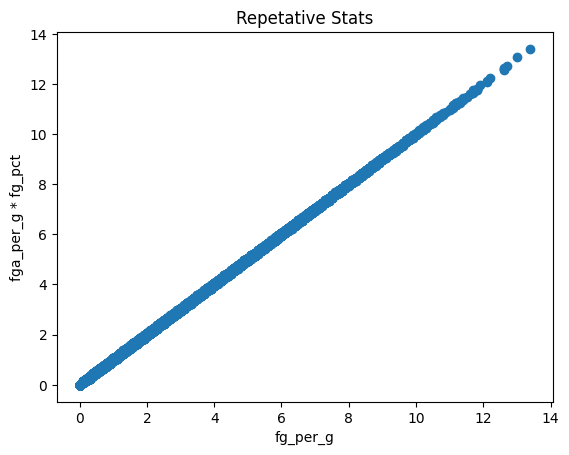

array([[1.        , 0.99990689],
       [0.99990689, 1.        ]])

In [5]:
import numpy as np

plt.scatter(df["fg_per_g"], df["fga_per_g"]*df["fg_pct"])
plt.xlabel("fg_per_g")
plt.ylabel("fga_per_g * fg_pct")
plt.title("Repetative Stats")
plt.show()
np.corrcoef(df["fg_per_g"], df["fga_per_g"]*df["fg_pct"])

### Remove fields that add no value

In [6]:
df = df.drop(columns = ["fg_per_g", "fg3_per_g", "fg2_per_g", "ft_per_g", "trb_per_g"], axis = 1)

### Remove years upto 1980-81 season when MVP voting began

In [7]:
df = df[df["season"] > 1981]
len(df)

17697

### Set 2017-2022 seasons as Test set

In [8]:
# Define the test set to include seasons 2017-2022
test_years = [2017, 2018, 2019, 2020, 2021, 2022]
dfTestSet = df[df["season"].isin(test_years)]
df = df[~df["season"].isin(test_years)]


### See what % of players in data received MVP votes

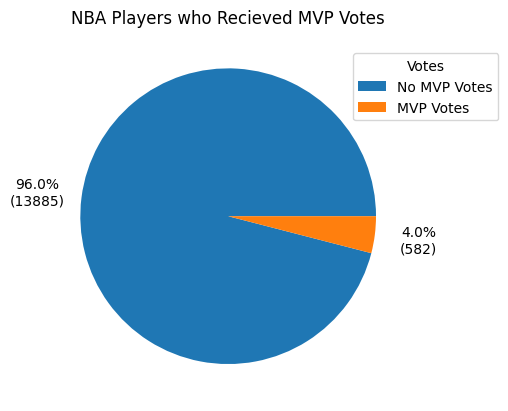

In [9]:
from collections import Counter

classes = df["award_share"] > 0
infoDf = df[["player", "pos", "team_id"]]
dataDf = df.drop(["player", "pos", "team_id"], axis = 1)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")
ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

### Players need to play a good number of games to receive MVP votes

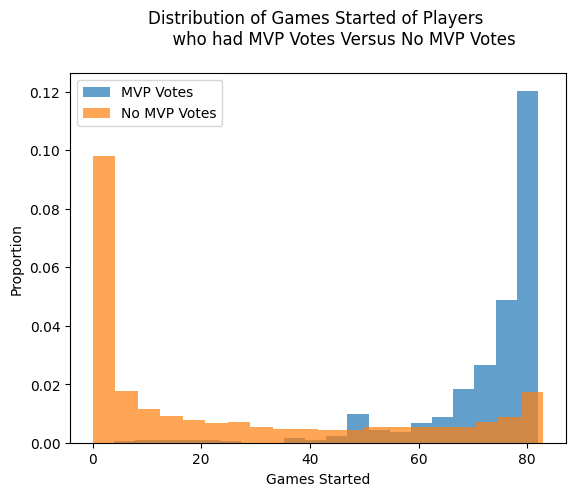

In [10]:
mvpShares = df[df["award_share"] > 0]
nonMvpShares = df[df["award_share"] == 0]

plt.hist(mvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Games Started")
plt.title("""Distribution of Games Started of Players 
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

## Who started less than 20 games and received votes? 

###### Derrick rose in 2020-21 - Played 50 games and only started 3 games, receiving a first-place MVP vote

###### MJ in 1994-95 - Returned to basketball just before playoffs, playing 17 games

## Finding those who started less than 20 games but received votes

In [11]:
mvpShares[mvpShares["gs"] < 20][["season", "player", "g", "gs", "pts_per_g", 'award_share']].reset_index(drop = True)

,season,player,g,gs,pts_per_g,award_share
0,1982,Michael Cooper,76,14,11.9,0.004
1,1991,Kevin McHale,68,10,18.4,0.001
2,1992,Detlef Schrempf,80,4,17.3,0.001
3,1995,Michael Jordan,17,17,26.9,0.011
4,1996,Magic Johnson,32,9,14.6,0.007
5,1999,Darrell Armstrong,50,15,13.8,0.002
6,1999,Rasheed Wallace,49,18,12.8,0.001


#### Take out players who played less than 20 games

In [12]:
df = df[df["gs"] > 20]
df = df.reset_index(drop = True)
len(df)

6156

## Need to play a significant amount of minutes to be MVP

#### Minimum =  3rd Standard Deviation from mean minutes played per game by MVP vote receiving players

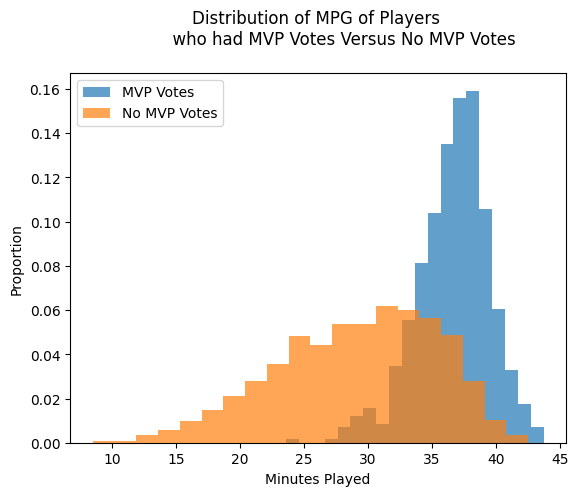

The cutoff is 28.107 minutes per game


In [13]:
mvpShares = df[df["award_share"] > 0]
nonMvpShares = df[df["award_share"] == 0]

plt.hist(mvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Minutes Played")
plt.title("""Distribution of MPG of Players 
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

mp_cutoff = mvpShares["mp_per_g"].mean() - 3*mvpShares["mp_per_g"].std()
print(f"The cutoff is {mp_cutoff:.3f} minutes per game")

### Players who played < 27.89 minutes but received MVP votes

In [14]:
mvpShares[mvpShares["mp_per_g"] < mp_cutoff][["season", "player", "mp_per_g", "pts_per_g", 'award_share']].reset_index(drop = True)

,season,player,mp_per_g,pts_per_g,award_share
0,1983,Alton Lister,23.6,8.4,0.007
1,1999,Arvydas Sabonis,27.0,12.1,0.003


## Repeat with points

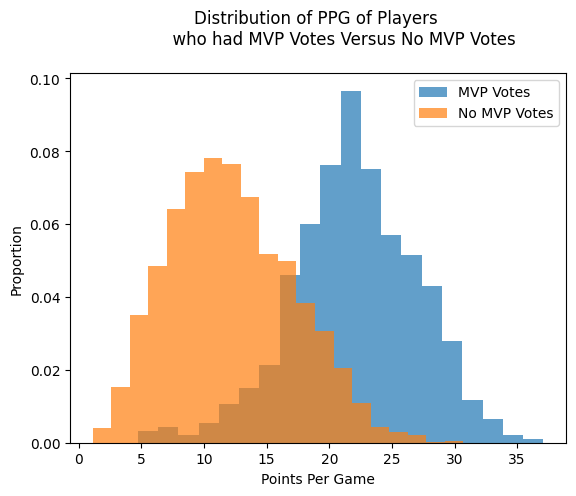

The cutoff is 6.850 points in a game


In [15]:
plt.hist(mvpShares["pts_per_g"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["pts_per_g"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.xlabel("Points Per Game")
plt.ylabel("Proportion")
plt.title("""Distribution of PPG of Players 
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

pts_cutoff = mvpShares["pts_per_g"].mean() - 3 * mvpShares["pts_per_g"].std()
print(f"The cutoff is {pts_cutoff:.3f} points in a game")

In [16]:
mvpShares[mvpShares["pts_per_g"] < pts_cutoff][["season", "player", "pts_per_g", 'blk_per_g', 'orb_per_g', 'drb_per_g', 'award_share']].reset_index(drop = True)

,season,player,pts_per_g,blk_per_g,orb_per_g,drb_per_g,award_share
0,1989,Mark Eaton,6.2,3.8,2.8,7.5,0.004
1,1994,Dennis Rodman,4.7,0.4,5.7,11.6,0.001
2,1996,Dennis Rodman,5.5,0.4,5.6,9.3,0.004


#### Dropped players combined have 12 DPOY awards but did not win MVP 

In [17]:
df = df[(df["pts_per_g"] > pts_cutoff) & (df["mp_per_g"] > mp_cutoff)].reset_index(drop = True)
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fga_per_g,fg_pct,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,was_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,17.1,0.579,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,13.0,0.494,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,9.6,0.472,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
3,1982,Greg Ballard,SF,27,WSB,79,79,37.3,16.5,0.475,...,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524,False
4,1982,Kent Benson,C,27,DET,75,72,32.9,10.7,0.505,...,0.101,0.0,0.4,0.4,1.5,0.000,-0.91,-0.63,0.476,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3831,2016,Andrew Wiggins,SF,20,MIN,81,81,35.1,16.0,0.459,...,0.069,0.9,-2.2,-1.3,0.5,0.000,-3.54,-3.38,0.354,False
3832,2016,Deron Williams,PG,31,DAL,65,63,32.4,11.9,0.414,...,0.083,0.4,-0.7,-0.3,0.9,0.000,-0.30,-0.02,0.512,False
3833,2016,Lou Williams,SG,29,LAL,67,35,28.5,10.3,0.408,...,0.119,2.4,-1.1,1.3,1.6,0.000,-9.56,-8.92,0.207,False
3834,2016,Marvin Williams,PF,29,CHO,81,81,28.9,9.2,0.452,...,0.161,2.1,0.5,2.7,2.7,0.000,2.72,2.36,0.585,False


### Check % of players who have no MVP votes

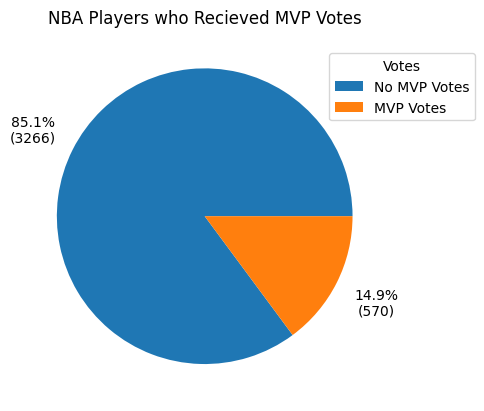

In [18]:
from collections import Counter
from imblearn.over_sampling import SMOTE

classes = df["award_share"] > 0

dataDf = df.drop(["player", "pos", "team_id", "was_mvp"], axis = 1)
unSmoteLen = len(dataDf)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

### Use SMOTE to oversample over minority class

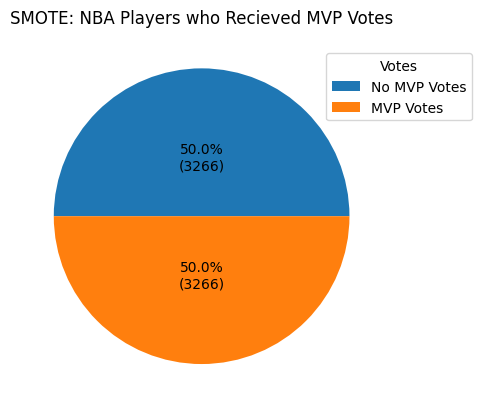

In [19]:
smote = SMOTE(sampling_strategy = 1)
dataDf, classes = smote.fit_resample(dataDf, classes)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 0.4)

ax.set_title("SMOTE: NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

### Add labels to denote the synthetic data

In [20]:
dataDf["is_smote"] = dataDf.index >= unSmoteLen
labeledDataDf = dataDf.merge(df, how = "left")

## Boruta method

In [21]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestRegressor(max_depth = 5, n_jobs=-1, n_estimators=500, oob_score=True)
trans = BorutaPy(rf, n_estimators = "auto", random_state=42, verbose=2)
selector = trans.fit(dataDf.drop(["award_share", "season", "is_smote"],axis= 1).to_numpy(), 
                     dataDf["award_share"].to_numpy())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	25
Tentative: 	20
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	25
Tentative: 	18
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	25
Tentative: 	18
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	25
Tentative: 	18
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	26
Tentative: 	14
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	26
Tentative: 	14
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	26
Tentative: 	14
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	26
Tentative: 	14
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	26
Tentative: 	14
Rejec

In [22]:
columns = dataDf.drop(["award_share", "season", "is_smote"],axis= 1).columns[selector.ranking_ <= 2]

## Splitting into training and testing sets

In [23]:
dfTestSet = dfTestSet[(dfTestSet["gs"] > 20) & (dfTestSet["pts_per_g"] > pts_cutoff) & (dfTestSet["mp_per_g"] > mp_cutoff)].reset_index(drop = True)

In [24]:
from pandas.api.types import is_hashable

# Shuffling the data
modelDf = labeledDataDf.sample(frac=1).reset_index(drop = True)

# Train Data
trainInfo = modelDf[["season", "player", "pos", "team_id","award_share",  "was_mvp", "is_smote"]]
trainData = modelDf[columns]
trainTargets = modelDf[["award_share"]]

# Test Data
testInfo = dfTestSet[["season", "player", "pos", "team_id", "award_share", "was_mvp"]]
testData = dfTestSet[columns]
testTargets = dfTestSet[["award_share"]]

### Using Random Forest Method (Supervised)

In [25]:
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season": [], "mae": [], "was_mvp": [], "was_top_two": [], "was_top_three": [], "info": []}

# Get unique seasons and sort them chronologically
seasons = sorted(trainInfo.season.unique())

for season in seasons:
    print("\n")
    print(f"Season: {season}")

    trainFold = trainData[trainInfo["season"] != season]
    trainTarFold = trainTargets[trainInfo["season"] != season]
    valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

    regr = RandomForestRegressor(max_depth=7, random_state=0)
    regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:, 0])

    valPred = regr.predict(valFold)
    mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:, 0]))

    print(f"MAE: {mae}")

    topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
    was_top_two = sum(topTwo["was_mvp"]) > 0
    topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
    was_top_three = sum(topThree["was_mvp"]) > 0
    print("Predicted top three players in MVP voting with their actual award_share:")
    print(topThree.iloc[::-1])

    mostVotes = np.argmax(valPred)
    score = np.amax(valPred)
    was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
    player = valInfo.iloc[[mostVotes]]["player"].values[0]
    print(f"Predicted MVP: {player}")
    print(f"Predicted Win Share: {score}")
    print(f"Was MVP correct: {was_mvp}")

    validation_scores["season"].append(season)
    validation_scores["mae"].append(mae)
    validation_scores["was_mvp"].append(was_mvp)
    validation_scores["was_top_two"].append(was_top_two)
    validation_scores["was_top_three"].append(was_top_three)
    validation_scores["info"].append(valInfo.iloc[[mostVotes]])




Season: 1982


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.017865607033660642
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5548    1982   Moses Malone   C     HOU        0.735    True     False
1444    1982  Julius Erving  SF     PHI        0.294   False     False
205     1982     Larry Bird  PF     BOS        0.588   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.4788396021296203
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018293303989173216
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4994    1983   Moses Malone   C     PHI        0.960    True     False
1176    1983     Larry Bird  PF     BOS        0.485   False     False
2830    1983  Magic Johnson  SG     LAL        0.406   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.45583620658946755
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.019573209753668733
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1402    1984      Larry Bird  PF     BOS        0.858    True     False
3883    1984   Magic Johnson  PG     LAL        0.401   False     False
3230    1984  Adrian Dantley  SF     UTA        0.116   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.4895330404132811
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011477015064806213
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
261     1985      Larry Bird  SF     BOS        0.978    True     False
5515    1985   Magic Johnson  PG     LAL        0.338   False     False
1619    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7838904658809632
Was MVP correct: True


Season: 1986


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014321900244985733
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
498     1986         Larry Bird  SF     BOS        0.981    True     False
5564    1986      Magic Johnson  PG     LAL        0.263   False     False
3897    1986  Dominique Wilkins  SF     ATL        0.522   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7584840515484406
Was MVP correct: True


Season: 1987


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012978955392894065
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1407    1987   Magic Johnson  PG     LAL        0.940    True     False
95      1987      Larry Bird  SF     BOS        0.347   False     False
344     1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.7685684343624368
Was MVP correct: True


Season: 1988


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01766882457887227
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
5306    1988   Michael Jordan  SG     CHI        0.831    True     False
1545    1988       Larry Bird  SF     BOS        0.659   False     False
1093    1988  Charles Barkley  PF     PHI        0.136   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6536634625307427
Was MVP correct: True


Season: 1989


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01479485556888896
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
867     1989  Michael Jordan  SG     CHI        0.704   False     False
3737    1989   Magic Johnson  PG     LAL        0.782    True     False
4420    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6745041011327486
Was MVP correct: False


Season: 1990


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.017466974584418486
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4539    1990    Magic Johnson  PG     LAL        0.691    True     False
4826    1990   Michael Jordan  SG     CHI        0.613   False     False
4588    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.817608659832849
Was MVP correct: True


Season: 1991


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0118328694130691
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3351    1991  Michael Jordan  SG     CHI        0.928    True     False
5331    1991  David Robinson   C     SAS        0.496   False     False
1958    1991   Magic Johnson  PG     LAL        0.518   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9177012172216716
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013989723315217265
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
2632    1992  Michael Jordan  SG     CHI        0.938    True     False
5561    1992   Clyde Drexler  SG     POR        0.584   False     False
1487    1992     Karl Malone  PF     UTA        0.273   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9376086154611774
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013763322603037123
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4725    1993  Charles Barkley  PF     PHO        0.852    True     False
4132    1993   Michael Jordan  SG     CHI        0.577   False     False
4321    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
Predicted MVP: Charles Barkley
Predicted Win Share: 0.6750588200663274
Was MVP correct: True


Season: 1994


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018162577912573145
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
91      1994    David Robinson   C     SAS        0.723   False     False
1269    1994   Hakeem Olajuwon   C     HOU        0.880    True     False
2616    1994  Shaquille O'Neal   C     ORL        0.286   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7203942401368056
Was MVP correct: False


Season: 1995


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01019645813616122
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4688    1995    David Robinson   C     SAS        0.858    True     False
3270    1995       Karl Malone  PF     UTA        0.507   False     False
4449    1995  Shaquille O'Neal   C     ORL        0.576   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7795594377926188
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01614483409771778
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
838     1996    Michael Jordan  SG     CHI        0.986    True     False
980     1996    David Robinson   C     SAS        0.508   False     False
6168    1996  Shaquille O'Neal   C     ORL        0.056   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9227086181837268
Was MVP correct: True


Season: 1997


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01341175667058164
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1838    1997  Michael Jordan  SG     CHI        0.832   False     False
2091    1997     Karl Malone  PF     UTA        0.857    True     False
2620    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8399303418394501
Was MVP correct: False


Season: 1998


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014353227727322006
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
764     1998     Karl Malone  PF     UTA        0.726   False     False
2831    1998  Michael Jordan  SG     CHI        0.934    True     False
862     1998  David Robinson   C     SAS        0.031   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.7515417613667315
Was MVP correct: False


Season: 1999


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.021980864170023314
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
3289    1999       Karl Malone  PF     UTA        0.701    True     False
1062    1999    David Robinson   C     SAS        0.005   False     False
5040    1999  Shaquille O'Neal   C     LAL        0.075   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.2045588388395746
Was MVP correct: True


Season: 2000


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0131355743833928
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5566    2000  Shaquille O'Neal   C     LAL        0.998    True     False
1495    2000        Tim Duncan  PF     SAS        0.205   False     False
1942    2000       Karl Malone  PF     UTA        0.258   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.8768371100575806
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.022731769309380447
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
457     2001     Allen Iverson  SG     PHI        0.904    True     False
742     2001  Shaquille O'Neal   C     LAL        0.466   False     False
3588    2001        Tim Duncan  PF     SAS        0.569   False     False
Predicted MVP: Allen Iverson
Predicted Win Share: 0.408836962859119
Was MVP correct: True


Season: 2002


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01935233342058702
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5002    2002        Tim Duncan  PF     SAS        0.757    True     False
3161    2002        Jason Kidd  PG     NJN        0.712   False     False
4388    2002  Shaquille O'Neal   C     LAL        0.552   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6374819667182315
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014149471811278196
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
174     2003     Tim Duncan  PF     SAS        0.808    True     False
3053    2003  Kevin Garnett  PF     MIN        0.732   False     False
2476    2003  Tracy McGrady  SG     ORL        0.359   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.5976494940038315
Was MVP correct: True


Season: 2004


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02036394516015182
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6273    2004  Kevin Garnett  PF     MIN        0.991    True     False
659     2004     Tim Duncan  PF     SAS        0.582   False     False
6373    2004    Baron Davis  PG     NOH        0.003   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.7407686527167577
Was MVP correct: True


Season: 2005


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.027165181557879798
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6407    2005   LeBron James  SF     CLE        0.073   False     False
2477    2005  Dirk Nowitzki  PF     DAL        0.275   False     False
2550    2005     Tim Duncan  PF     SAS        0.258   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.368484397013464
Was MVP correct: False


Season: 2006


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02617258860003806
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1755    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
4625    2006   LeBron James  SF     CLE        0.550   False     False
1965    2006    Kobe Bryant  SG     LAL        0.386   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.5393132919533294
Was MVP correct: False


Season: 2007


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.017994899501161364
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
688     2007  Dirk Nowitzki  PF     DAL        0.882    True     False
3616    2007     Steve Nash  PG     PHO        0.785   False     False
1789    2007     Tim Duncan   C     SAS        0.222   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.7079475618428519
Was MVP correct: True


Season: 2008


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02264187480377712
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
4704    2008   Kobe Bryant  SG     LAL        0.873    True     False
1538    2008  LeBron James  SF     CLE        0.348   False     False
2484    2008    Chris Paul  PG     NOH        0.710   False     False
Predicted MVP: Kobe Bryant
Predicted Win Share: 0.5909301836432609
Was MVP correct: True


Season: 2009


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015996366538034972
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3132    2009  LeBron James  SF     CLE        0.969    True     False
376     2009    Chris Paul  PG     NOH        0.159   False     False
4847    2009   Dwyane Wade  SG     MIA        0.562   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9106516231458712
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016663297619581952
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3274    2010  LeBron James  SF     CLE        0.980    True     False
5935    2010  Kevin Durant  SF     OKC        0.495   False     False
1981    2010   Dwyane Wade  SG     MIA        0.097   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8797560540916516
Was MVP correct: True


Season: 2011


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02076375294188763
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
1419    2011  LeBron James  SF     MIA        0.431   False     False
6369    2011   Dwyane Wade  SG     MIA        0.020   False     False
1727    2011  Derrick Rose  PG     CHI        0.977    True     False
Predicted MVP: LeBron James
Predicted Win Share: 0.47541849900238264
Was MVP correct: False


Season: 2012


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02125851185445858
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
1568    2012  LeBron James  SF     MIA        0.888    True     False
1358    2012  Kevin Durant  SF     OKC        0.735   False     False
5253    2012   Kobe Bryant  SG     LAL        0.291   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5532796167215148
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01343636201153003
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
4788    2013  LeBron James  PF     MIA        0.998    True     False
6283    2013  Kevin Durant  SF     OKC        0.632   False     False
5768    2013    Chris Paul  PG     LAC        0.239   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.87797014698025
Was MVP correct: True


Season: 2014


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016973938842976117
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
5641    2014  Kevin Durant  SF     OKC        0.986    True     False
4093    2014  LeBron James  PF     MIA        0.713   False     False
1131    2014    Kevin Love  PF     MIN        0.020   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.7467938350702837
Was MVP correct: True


Season: 2015


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014771469545675433
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5647    2015  Stephen Curry  PG     GSW        0.922    True     False
5988    2015   James Harden  SG     HOU        0.720   False     False
2128    2015   LeBron James  SF     CLE        0.425   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.826411132395312
Was MVP correct: True


Season: 2016
MAE: 0.017710392353241712
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4456    2016  Stephen Curry  PG     GSW        1.000    True     False
1984    2016  Kawhi Leonard  SF     SAS        0.484   False     False
1930    2016   Kevin Durant  SF     OKC        0.112   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.8891196638514218
Was MVP correct: True


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [26]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(validation_scores['was_mvp']) * 100}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(validation_scores['was_top_two']) * 100}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(validation_scores['was_top_three']) * 100}% of the time")


The Random Forest Model predicted the NBA MVP correctly 80.0% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 91.42857142857143% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 94.28571428571428% of the time


In [29]:
# Test Data
testInfo = dfTestSet[["season", "player", "pos", "team_id", "award_share", "was_mvp"]]
testData = dfTestSet[columns]
testTargets = dfTestSet[["award_share"]]

# Make predictions on the test set
testPred = regr.predict(testData)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.absolute(testPred - testTargets.to_numpy()[:, 0]))
print(f"MAE on the test set (seasons 2017-2022): {mae}")

# Analyze specific predictions based on your requirements
for season in testInfo["season"].unique():
    season_data = testInfo[testInfo["season"] == season]
    most_votes = np.argmax(testPred[season_data.index])
    predicted_mvp = season_data.iloc[[most_votes]]["player"].values[0]
    actual_mvp = season_data[season_data["was_mvp"]]["player"].values[0]  # Get the actual MVP from the 'was_mvp' column
    actual_mvp_award_share = season_data[season_data["was_mvp"]]["award_share"].values[0]

    print(f"Season {season}: Predicted MVP: {predicted_mvp}, Actual MVP: {actual_mvp}")
    print(f"Actual Award Share for Actual MVP: {actual_mvp_award_share}")


MAE on the test set (seasons 2017-2022): 0.02650269541831141
Season 2017: Predicted MVP: Kawhi Leonard, Actual MVP: Russell Westbrook
Actual Award Share for Actual MVP: 0.879
Season 2018: Predicted MVP: James Harden, Actual MVP: James Harden
Actual Award Share for Actual MVP: 0.955
Season 2019: Predicted MVP: James Harden, Actual MVP: Giannis Antetokounmpo
Actual Award Share for Actual MVP: 0.932
Season 2020: Predicted MVP: Giannis Antetokounmpo, Actual MVP: Giannis Antetokounmpo
Actual Award Share for Actual MVP: 0.952
Season 2021: Predicted MVP: Nikola Jokic, Actual MVP: Nikola Jokic
Actual Award Share for Actual MVP: 0.961
Season 2022: Predicted MVP: Nikola Jokic, Actual MVP: Nikola Jokic
Actual Award Share for Actual MVP: 0.875


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create a pipeline with preprocessing steps and the RandomForestRegressor
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Replace missing values with the mean
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', RandomForestRegressor(random_state=0))  # RandomForestRegressor
])

# Define hyperparameters grid for tuning
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 7, 10],
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(trainData, trainTargets.values.ravel())  # ravel() to convert the target to 1D array

# Get the best model from the grid search
best_regressor = grid_search.best_estimator_

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Re-initialize validation_scores for the best model
validation_scores = {"season": [], "mae": [], "was_mvp": [], "was_top_two": [], "was_top_three": [], "info": []}

# Get unique seasons and sort them chronologically
seasons = sorted(trainInfo.season.unique())

for season in seasons:
    print("\n")
    print(f"Season: {season}")

    trainFold = trainData[trainInfo["season"] != season]
    trainTarFold = trainTargets[trainInfo["season"] != season]
    valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

    best_regressor.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:, 0])

    valPred = best_regressor.predict(valFold)
    mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:, 0]))

    print(f"MAE: {mae}")

    topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
    was_top_two = sum(topTwo["was_mvp"]) > 0
    topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
    was_top_three = sum(topThree["was_mvp"]) > 0
    print("Predicted top three players in MVP voting with their actual award_share:")
    print(topThree.iloc[::-1])

    mostVotes = np.argmax(valPred)
    score = np.amax(valPred)
    was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
    player = valInfo.iloc[[mostVotes]]["player"].values[0]
    print(f"Predicted MVP: {player}")
    print(f"Predicted Win Share: {score}")
    print(f"Was MVP correct: {was_mvp}")

    validation_scores["season"].append(season)
    validation_scores["mae"].append(mae)
    validation_scores["was_mvp"].append(was_mvp)
    validation_scores["was_top_two"].append(was_top_two)
    validation_scores["was_top_three"].append(was_top_three)
    validation_scores["info"].append(valInfo.iloc[[mostVotes]])


Best Hyperparameters: {'regressor__max_depth': 10, 'regressor__n_estimators': 300}


Season: 1982


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.015769436484199328
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5548    1982   Moses Malone   C     HOU        0.735    True     False
205     1982     Larry Bird  PF     BOS        0.588   False     False
1444    1982  Julius Erving  SF     PHI        0.294   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.551728116662604
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01703515981437276
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4994    1983   Moses Malone   C     PHI        0.960    True     False
1176    1983     Larry Bird  PF     BOS        0.485   False     False
2830    1983  Magic Johnson  SG     LAL        0.406   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.4963475244358307
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01877524587722253
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1402    1984      Larry Bird  PF     BOS        0.858    True     False
3883    1984   Magic Johnson  PG     LAL        0.401   False     False
3230    1984  Adrian Dantley  SF     UTA        0.116   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.528044844996681
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.009375382024798717
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
261     1985      Larry Bird  SF     BOS        0.978    True     False
5515    1985   Magic Johnson  PG     LAL        0.338   False     False
1619    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7910830326639557
Was MVP correct: True


Season: 1986


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01359636347106099
Predicted top three players in MVP voting with their actual award_share:
      season               player pos team_id  award_share was_mvp  is_smote
498     1986           Larry Bird  SF     BOS        0.981    True     False
5564    1986        Magic Johnson  PG     LAL        0.263   False     False
5212    1986  Kareem Abdul-Jabbar   C     LAL        0.173   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7559366405273933
Was MVP correct: True


Season: 1987


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.0134615740275683
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1407    1987   Magic Johnson  PG     LAL        0.940    True     False
95      1987      Larry Bird  SF     BOS        0.347   False     False
344     1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.780531813720749
Was MVP correct: True


Season: 1988


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01584970029866098
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
5306    1988  Michael Jordan  SG     CHI        0.831    True     False
1545    1988      Larry Bird  SF     BOS        0.659   False     False
5188    1988   Magic Johnson  PG     LAL        0.635   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6605016761777546
Was MVP correct: True


Season: 1989


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.013796748263196382
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
867     1989  Michael Jordan  SG     CHI        0.704   False     False
3737    1989   Magic Johnson  PG     LAL        0.782    True     False
4420    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6562088577079698
Was MVP correct: False


Season: 1990


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.015692967682776914
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4539    1990    Magic Johnson  PG     LAL        0.691    True     False
4826    1990   Michael Jordan  SG     CHI        0.613   False     False
4588    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.8139026091860505
Was MVP correct: True


Season: 1991


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.009960078738289404
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3351    1991  Michael Jordan  SG     CHI        0.928    True     False
5331    1991  David Robinson   C     SAS        0.496   False     False
1958    1991   Magic Johnson  PG     LAL        0.518   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9236372970102413
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.011836427190694644
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
2632    1992  Michael Jordan  SG     CHI        0.938    True     False
5561    1992   Clyde Drexler  SG     POR        0.584   False     False
1487    1992     Karl Malone  PF     UTA        0.273   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9284297012871459
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.012577380240233962
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4132    1993   Michael Jordan  SG     CHI        0.577   False     False
4725    1993  Charles Barkley  PF     PHO        0.852    True     False
4321    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7102292501723365
Was MVP correct: False


Season: 1994


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.015816754542233216
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
91      1994    David Robinson   C     SAS        0.723   False     False
1269    1994   Hakeem Olajuwon   C     HOU        0.880    True     False
2616    1994  Shaquille O'Neal   C     ORL        0.286   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7260739501852349
Was MVP correct: False


Season: 1995


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.010208459983049398
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4688    1995    David Robinson   C     SAS        0.858    True     False
3270    1995       Karl Malone  PF     UTA        0.507   False     False
4449    1995  Shaquille O'Neal   C     ORL        0.576   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.762617899034294
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.013581502206080247
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
838     1996     Michael Jordan  SG     CHI        0.986    True     False
980     1996     David Robinson   C     SAS        0.508   False     False
6361    1996  Anfernee Hardaway  PG     ORL        0.319   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.922550503511114
Was MVP correct: True


Season: 1997


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.011416329696779371
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1838    1997  Michael Jordan  SG     CHI        0.832   False     False
2091    1997     Karl Malone  PF     UTA        0.857    True     False
2620    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8386021827502236
Was MVP correct: False


Season: 1998


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.011873595904300217
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
764     1998       Karl Malone  PF     UTA        0.726   False     False
2831    1998    Michael Jordan  SG     CHI        0.934    True     False
1376    1998  Shaquille O'Neal   C     LAL        0.268   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.7410806754669442
Was MVP correct: False


Season: 1999


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.020473638358322555
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3289    1999     Karl Malone  PF     UTA        0.701    True     False
1062    1999  David Robinson   C     SAS        0.005   False     False
5339    1999      Tim Duncan  PF     SAS        0.627   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.2560429941128217
Was MVP correct: True


Season: 2000


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.0115771371288089
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5566    2000  Shaquille O'Neal   C     LAL        0.998    True     False
1495    2000        Tim Duncan  PF     SAS        0.205   False     False
1942    2000       Karl Malone  PF     UTA        0.258   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.8712441943970176
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.019463542351037057
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
457     2001     Allen Iverson  SG     PHI        0.904    True     False
742     2001  Shaquille O'Neal   C     LAL        0.466   False     False
3588    2001        Tim Duncan  PF     SAS        0.569   False     False
Predicted MVP: Allen Iverson
Predicted Win Share: 0.5450376442040443
Was MVP correct: True


Season: 2002


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.016286527211309153
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5002    2002        Tim Duncan  PF     SAS        0.757    True     False
3161    2002        Jason Kidd  PG     NJN        0.712   False     False
4388    2002  Shaquille O'Neal   C     LAL        0.552   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.670927087470944
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.012882971617415386
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
174     2003     Tim Duncan  PF     SAS        0.808    True     False
3053    2003  Kevin Garnett  PF     MIN        0.732   False     False
2476    2003  Tracy McGrady  SG     ORL        0.359   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6295266606734667
Was MVP correct: True


Season: 2004


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.018119127337492606
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6273    2004  Kevin Garnett  PF     MIN        0.991    True     False
659     2004     Tim Duncan  PF     SAS        0.582   False     False
6373    2004    Baron Davis  PG     NOH        0.003   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.8326099310410058
Was MVP correct: True


Season: 2005


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.023063916073150757
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
3795    2005  Shaquille O'Neal   C     MIA        0.813   False     False
6407    2005      LeBron James  SF     CLE        0.073   False     False
2550    2005        Tim Duncan  PF     SAS        0.258   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.3816865322388241
Was MVP correct: False


Season: 2006


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.022953791699483826
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1755    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
4625    2006   LeBron James  SF     CLE        0.550   False     False
1965    2006    Kobe Bryant  SG     LAL        0.386   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.5219980954115393
Was MVP correct: False


Season: 2007


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01568152965886181
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
688     2007  Dirk Nowitzki  PF     DAL        0.882    True     False
3616    2007     Steve Nash  PG     PHO        0.785   False     False
1789    2007     Tim Duncan   C     SAS        0.222   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.7279415228150922
Was MVP correct: True


Season: 2008


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.019556521401256344
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
4704    2008   Kobe Bryant  SG     LAL        0.873    True     False
2484    2008    Chris Paul  PG     NOH        0.710   False     False
1538    2008  LeBron James  SF     CLE        0.348   False     False
Predicted MVP: Kobe Bryant
Predicted Win Share: 0.6983231588289401
Was MVP correct: True


Season: 2009


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01340939456277392
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3132    2009  LeBron James  SF     CLE        0.969    True     False
4847    2009   Dwyane Wade  SG     MIA        0.562   False     False
376     2009    Chris Paul  PG     NOH        0.159   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9162685327604134
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.014733741111604337
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3274    2010  LeBron James  SF     CLE        0.980    True     False
5935    2010  Kevin Durant  SF     OKC        0.495   False     False
1981    2010   Dwyane Wade  SG     MIA        0.097   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8866628665459245
Was MVP correct: True


Season: 2011


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.017185143419736135
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1419    2011   LeBron James  SF     MIA        0.431   False     False
1727    2011   Derrick Rose  PG     CHI        0.977    True     False
1585    2011  Dwight Howard   C     ORL        0.531   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.44781570710145974
Was MVP correct: False


Season: 2012


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.016278915280456704
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
1568    2012  LeBron James  SF     MIA        0.888    True     False
1358    2012  Kevin Durant  SF     OKC        0.735   False     False
5253    2012   Kobe Bryant  SG     LAL        0.291   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6181747282063157
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.010663268383332005
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4788    2013     LeBron James  PF     MIA        0.998    True     False
6283    2013     Kevin Durant  SF     OKC        0.632   False     False
3652    2013  Carmelo Anthony  PF     NYK        0.393   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8826743770116682
Was MVP correct: True


Season: 2014


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.013059146019137517
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
5641    2014  Kevin Durant  SF     OKC        0.986    True     False
4093    2014  LeBron James  PF     MIA        0.713   False     False
1131    2014    Kevin Love  PF     MIN        0.020   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.846468858796887
Was MVP correct: True


Season: 2015


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01148795935262881
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5647    2015  Stephen Curry  PG     GSW        0.922    True     False
5988    2015   James Harden  SG     HOU        0.720   False     False
2128    2015   LeBron James  SF     CLE        0.425   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.8480405070129189
Was MVP correct: True


Season: 2016
MAE: 0.01575934643284493
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4456    2016  Stephen Curry  PG     GSW        1.000    True     False
1984    2016  Kawhi Leonard  SF     SAS        0.484   False     False
1930    2016   Kevin Durant  SF     OKC        0.112   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.8901933292597649
Was MVP correct: True


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [31]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(validation_scores['was_mvp']) * 100}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(validation_scores['was_top_two']) * 100}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(validation_scores['was_top_three']) * 100}% of the time")


The Random Forest Model predicted the NBA MVP correctly 77.14285714285715% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 94.28571428571428% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 94.28571428571428% of the time


In [33]:
# Test set for specific years
test_years = [2017, 2018, 2019, 2020, 2021, 2022]
test_set_specific_years = dfTestSet[dfTestSet["season"].isin(test_years)]

# Test Data
testInfo = test_set_specific_years[["season", "player", "pos", "team_id", "award_share", "was_mvp"]]
testData = test_set_specific_years[columns]
testTargets = test_set_specific_years[["award_share"]]

# Make predictions on the test set
testPred = best_regressor.predict(testData)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.absolute(testPred - testTargets.to_numpy()[:, 0]))
print(f"MAE on the test set (seasons 2017-2022): {mae}")

# Analyze specific predictions based on your requirements
for season in testInfo["season"].unique():
    season_data = testInfo[testInfo["season"] == season]
    most_votes = np.argmax(testPred[season_data.index])
    predicted_mvp = season_data.iloc[[most_votes]]["player"].values[0]
    actual_mvp = season_data[season_data["was_mvp"]]["player"].values[0]  # Get the actual MVP from the 'was_mvp' column
    actual_mvp_award_share = season_data[season_data["was_mvp"]]["award_share"].values[0]

    print(f"Season {season}: Predicted MVP: {predicted_mvp}, Actual MVP: {actual_mvp}")
    print(f"Actual Award Share for Actual MVP: {actual_mvp_award_share}")


MAE on the test set (seasons 2017-2022): 0.025603405979502395
Season 2017: Predicted MVP: Kawhi Leonard, Actual MVP: Russell Westbrook
Actual Award Share for Actual MVP: 0.879
Season 2018: Predicted MVP: James Harden, Actual MVP: James Harden
Actual Award Share for Actual MVP: 0.955
Season 2019: Predicted MVP: James Harden, Actual MVP: Giannis Antetokounmpo
Actual Award Share for Actual MVP: 0.932
Season 2020: Predicted MVP: Giannis Antetokounmpo, Actual MVP: Giannis Antetokounmpo
Actual Award Share for Actual MVP: 0.952
Season 2021: Predicted MVP: Nikola Jokic, Actual MVP: Nikola Jokic
Actual Award Share for Actual MVP: 0.961
Season 2022: Predicted MVP: Nikola Jokic, Actual MVP: Nikola Jokic
Actual Award Share for Actual MVP: 0.875


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [34]:
# Display the column names in trainTargets
print(trainTargets.columns)

Index(['award_share'], dtype='object')


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

# Create a pipeline with preprocessing steps and the RandomForestRegressor
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Replace missing values with the mean
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', RandomForestRegressor(n_estimators=500, max_depth=5, random_state=0))  # RandomForestRegressor with specified hyperparameters
])

# Define hyperparameters grid for tuning
param_grid = {
    'regressor__n_estimators': [500],
    'regressor__max_depth': [5],
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='neg_mean_absolute_error')  # Use MAE as the scoring metric
grid_search.fit(trainData, trainTargets.values.ravel())  # ravel() to convert the target to a 1D array

# Get the best model from the grid search
best_regressor = grid_search.best_estimator_

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Re-initialize validation_scores for the best model
validation_scores = {
    "season": [], 
    "mae": [], 
    "was_mvp": [], 
    "was_top_two": [], 
    "was_top_three": [], 
    "info": [], 
    "mse": [],
    "explained_variance": []
}

# Get unique seasons and sort them chronologically
seasons = sorted(trainInfo.season.unique())

for season in seasons:
    print("\n")
    print(f"Season: {season}")

    trainFold = trainData[trainInfo["season"] != season]
    trainTarFold = trainTargets[trainInfo["season"] != season]
    valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

    best_regressor.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:, 0])

    valPred = best_regressor.predict(valFold)
    mae = mean_absolute_error(valTarFold.to_numpy()[:, 0], valPred)
    mse = mean_squared_error(valTarFold.to_numpy()[:, 0], valPred)
    explained_var = explained_variance_score(valTarFold.to_numpy()[:, 0], valPred)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"Explained Variance: {explained_var}")

    topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
    was_top_two = sum(topTwo["was_mvp"]) > 0
    topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
    was_top_three = sum(topThree["was_mvp"]) > 0
    print("Predicted top three players in MVP voting with their actual award_share:")
    print(topThree.iloc[::-1])

    mostVotes = np.argmax(valPred)
    score = np.amax(valPred)
    was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
    player = valInfo.iloc[[mostVotes]]["player"].values[0]
    print(f"Predicted MVP: {player}")
    print(f"Predicted Win Share: {score}")
    print(f"Was MVP correct: {was_mvp}")

    validation_scores["season"].append(season)
    validation_scores["mae"].append(mae)
    validation_scores["was_mvp"].append(was_mvp)
    validation_scores["was_top_two"].append(was_top_two)
    validation_scores["was_top_three"].append(was_top_three)
    validation_scores["info"].append(valInfo.iloc[[mostVotes]])
    validation_scores["mse"].append(mse)
    validation_scores["explained_variance"].append(explained_var)


Best Hyperparameters: {'regressor__max_depth': 5, 'regressor__n_estimators': 500}


Season: 1982


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.02041821411482258
MSE: 0.00366418296019647
Explained Variance: 0.7092500743316787
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5548    1982   Moses Malone   C     HOU        0.735    True     False
1444    1982  Julius Erving  SF     PHI        0.294   False     False
205     1982     Larry Bird  PF     BOS        0.588   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.3658072400605576
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.020354149025856968
MSE: 0.00407532775736016
Explained Variance: 0.7254800987746522
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4994    1983   Moses Malone   C     PHI        0.960    True     False
2830    1983  Magic Johnson  SG     LAL        0.406   False     False
1176    1983     Larry Bird  PF     BOS        0.485   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.4718745335342134
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.021149725536881096
MSE: 0.00535208469003499
Explained Variance: 0.6267748987105299
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1402    1984      Larry Bird  PF     BOS        0.858    True     False
3883    1984   Magic Johnson  PG     LAL        0.401   False     False
3230    1984  Adrian Dantley  SF     UTA        0.116   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.43689339757396944
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.012341811529850146
MSE: 0.0009755147891534515
Explained Variance: 0.9257451484174455
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
261     1985      Larry Bird  SF     BOS        0.978    True     False
5515    1985   Magic Johnson  PG     LAL        0.338   False     False
1619    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.8054073477447163
Was MVP correct: True


Season: 1986


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01605893372322108
MSE: 0.0029275060628819244
Explained Variance: 0.8139288078958489
Predicted top three players in MVP voting with their actual award_share:
      season               player pos team_id  award_share was_mvp  is_smote
498     1986           Larry Bird  SF     BOS        0.981    True     False
5564    1986        Magic Johnson  PG     LAL        0.263   False     False
5212    1986  Kareem Abdul-Jabbar   C     LAL        0.173   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7371848306955439
Was MVP correct: True


Season: 1987


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.014373645140440707
MSE: 0.0014180723694689904
Explained Variance: 0.9109799338401353
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1407    1987   Magic Johnson  PG     LAL        0.940    True     False
95      1987      Larry Bird  SF     BOS        0.347   False     False
344     1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.7634479035924028
Was MVP correct: True


Season: 1988


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01945942579194056
MSE: 0.0031449682122326617
Explained Variance: 0.8209761464984507
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
5306    1988   Michael Jordan  SG     CHI        0.831    True     False
1545    1988       Larry Bird  SF     BOS        0.659   False     False
1093    1988  Charles Barkley  PF     PHI        0.136   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6300805051487526
Was MVP correct: True


Season: 1989


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.018082584969832977
MSE: 0.0023459087038843816
Explained Variance: 0.8262199439868662
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
867     1989  Michael Jordan  SG     CHI        0.704   False     False
3737    1989   Magic Johnson  PG     LAL        0.782    True     False
4420    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.5959766181688232
Was MVP correct: False


Season: 1990


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.019312965940271622
MSE: 0.0025657218588267597
Explained Variance: 0.8047305698644341
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4539    1990    Magic Johnson  PG     LAL        0.691    True     False
4826    1990   Michael Jordan  SG     CHI        0.613   False     False
4588    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.8392303622026944
Was MVP correct: True


Season: 1991


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01489893359428767
MSE: 0.0016144028007121464
Explained Variance: 0.8782482048724305
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3351    1991  Michael Jordan  SG     CHI        0.928    True     False
5331    1991  David Robinson   C     SAS        0.496   False     False
1958    1991   Magic Johnson  PG     LAL        0.518   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8985588147408794
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.016341455141913992
MSE: 0.001944698415808475
Explained Variance: 0.8560566470650548
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
2632    1992  Michael Jordan  SG     CHI        0.938    True     False
5561    1992   Clyde Drexler  SG     POR        0.584   False     False
1487    1992     Karl Malone  PF     UTA        0.273   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9081064735189825
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01667298231026343
MSE: 0.0022598637286257444
Explained Variance: 0.8500349710490502
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4132    1993   Michael Jordan  SG     CHI        0.577   False     False
4725    1993  Charles Barkley  PF     PHO        0.852    True     False
4321    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6765832983040311
Was MVP correct: False


Season: 1994


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.021287005711453207
MSE: 0.003725145153026731
Explained Variance: 0.7500054440308261
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
91      1994    David Robinson   C     SAS        0.723   False     False
1269    1994   Hakeem Olajuwon   C     HOU        0.880    True     False
2616    1994  Shaquille O'Neal   C     ORL        0.286   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.6936097309225022
Was MVP correct: False


Season: 1995


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.013054648711371403
MSE: 0.0011468868497175977
Explained Variance: 0.9023474279471582
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4688    1995    David Robinson   C     SAS        0.858    True     False
3270    1995       Karl Malone  PF     UTA        0.507   False     False
4449    1995  Shaquille O'Neal   C     ORL        0.576   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7751329380809244
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.016389818670865298
MSE: 0.001646241658706603
Explained Variance: 0.8642357718493986
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
838     1996  Michael Jordan  SG     CHI        0.986    True     False
980     1996  David Robinson   C     SAS        0.508   False     False
6213    1996     Karl Malone  PF     UTA        0.075   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9044155863847202
Was MVP correct: True


Season: 1997


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.015393489709443748
MSE: 0.0014147280945027054
Explained Variance: 0.8900161538195784
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1838    1997  Michael Jordan  SG     CHI        0.832   False     False
2091    1997     Karl Malone  PF     UTA        0.857    True     False
2620    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8560179611446503
Was MVP correct: False


Season: 1998


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01581352285266312
MSE: 0.0025605364337482825
Explained Variance: 0.802446146513707
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
764     1998     Karl Malone  PF     UTA        0.726   False     False
2831    1998  Michael Jordan  SG     CHI        0.934    True     False
862     1998  David Robinson   C     SAS        0.031   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.7012326487053788
Was MVP correct: False


Season: 1999


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.024687767730364796
MSE: 0.008996666567011685
Explained Variance: 0.2833959791602576
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1062    1999    David Robinson   C     SAS        0.005   False     False
3289    1999       Karl Malone  PF     UTA        0.701    True     False
5040    1999  Shaquille O'Neal   C     LAL        0.075   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.19408045760629442
Was MVP correct: False


Season: 2000


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.014882891545619524
MSE: 0.0015358456799071194
Explained Variance: 0.8723189290351434
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5566    2000  Shaquille O'Neal   C     LAL        0.998    True     False
1942    2000       Karl Malone  PF     UTA        0.258   False     False
1495    2000        Tim Duncan  PF     SAS        0.205   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.8710343119401572
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.026557096218882918
MSE: 0.0062416539828222825
Explained Variance: 0.529210239171973
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
742     2001  Shaquille O'Neal   C     LAL        0.466   False     False
3588    2001        Tim Duncan  PF     SAS        0.569   False     False
4810    2001      Chris Webber  PF     SAC        0.420   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.33461255876852153
Was MVP correct: False


Season: 2002


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.022985764048142093
MSE: 0.0033758076804248677
Explained Variance: 0.7345969498287218
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5002    2002        Tim Duncan  PF     SAS        0.757    True     False
3161    2002        Jason Kidd  PG     NJN        0.712   False     False
4388    2002  Shaquille O'Neal   C     LAL        0.552   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.5575232089354373
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.017404114090248224
MSE: 0.0029729925504139902
Explained Variance: 0.756396843014162
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
174     2003     Tim Duncan  PF     SAS        0.808    True     False
2476    2003  Tracy McGrady  SG     ORL        0.359   False     False
4681    2003    Kobe Bryant  SG     LAL        0.417   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.5112404625140662
Was MVP correct: True


Season: 2004


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.022843553308871195
MSE: 0.00474796756089654
Explained Variance: 0.6303501948413794
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6273    2004  Kevin Garnett  PF     MIN        0.991    True     False
6373    2004    Baron Davis  PG     NOH        0.003   False     False
659     2004     Tim Duncan  PF     SAS        0.582   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.6695315319801941
Was MVP correct: True


Season: 2005


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.03406103704452421
MSE: 0.011435276144663477
Explained Variance: 0.10715858177043247
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6407    2005   LeBron James  SF     CLE        0.073   False     False
2477    2005  Dirk Nowitzki  PF     DAL        0.275   False     False
4102    2005  Kevin Garnett  PF     MIN        0.012   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.41109399724024864
Was MVP correct: False


Season: 2006


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.028220841361661753
MSE: 0.005260572236683601
Explained Variance: 0.5560067082471988
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1755    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
4625    2006   LeBron James  SF     CLE        0.550   False     False
1965    2006    Kobe Bryant  SG     LAL        0.386   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.5683437518257216
Was MVP correct: False


Season: 2007


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.021365902764852906
MSE: 0.003165323965775444
Explained Variance: 0.7668360194486155
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
688     2007  Dirk Nowitzki  PF     DAL        0.882    True     False
3616    2007     Steve Nash  PG     PHO        0.785   False     False
1789    2007     Tim Duncan   C     SAS        0.222   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.6640163113168686
Was MVP correct: True


Season: 2008


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.025961963004064822
MSE: 0.004698392923247564
Explained Variance: 0.6615808012969002
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
1538    2008  LeBron James  SF     CLE        0.348   False     False
4704    2008   Kobe Bryant  SG     LAL        0.873    True     False
2484    2008    Chris Paul  PG     NOH        0.710   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.450127678956894
Was MVP correct: False


Season: 2009


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.018267865735251635
MSE: 0.0027178928475475326
Explained Variance: 0.7882407440525603
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3132    2009  LeBron James  SF     CLE        0.969    True     False
376     2009    Chris Paul  PG     NOH        0.159   False     False
4847    2009   Dwyane Wade  SG     MIA        0.562   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8861740040808015
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.01889509515121584
MSE: 0.0028642510028641043
Explained Variance: 0.7755683269375047
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3274    2010  LeBron James  SF     CLE        0.980    True     False
5935    2010  Kevin Durant  SF     OKC        0.495   False     False
1981    2010   Dwyane Wade  SG     MIA        0.097   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.876667888937318
Was MVP correct: True


Season: 2011


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.02328097896619074
MSE: 0.006546863936215663
Explained Variance: 0.5151818787587574
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
1419    2011  LeBron James  SF     MIA        0.431   False     False
6369    2011   Dwyane Wade  SG     MIA        0.020   False     False
1727    2011  Derrick Rose  PG     CHI        0.977    True     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5018122281083255
Was MVP correct: False


Season: 2012


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.027094842194779447
MSE: 0.005587430870470806
Explained Variance: 0.6230714199028873
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
1568    2012  LeBron James  SF     MIA        0.888    True     False
1358    2012  Kevin Durant  SF     OKC        0.735   False     False
1148    2012   Dwyane Wade  SG     MIA        0.005   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5070044439062356
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.016359455254952932
MSE: 0.001654730435578464
Explained Variance: 0.8884261713959354
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
4788    2013  LeBron James  PF     MIA        0.998    True     False
6283    2013  Kevin Durant  SF     OKC        0.632   False     False
5768    2013    Chris Paul  PG     LAC        0.239   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8535921393304486
Was MVP correct: True


Season: 2014


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.021581827208364275
MSE: 0.0035276133268605132
Explained Variance: 0.7317314444479323
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
5641    2014  Kevin Durant  SF     OKC        0.986    True     False
4093    2014  LeBron James  PF     MIA        0.713   False     False
1131    2014    Kevin Love  PF     MIN        0.020   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.6557730569392767
Was MVP correct: True


Season: 2015


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


MAE: 0.018657370317477714
MSE: 0.0017958326605720643
Explained Variance: 0.8725872700891009
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5647    2015  Stephen Curry  PG     GSW        0.922    True     False
5988    2015   James Harden  SG     HOU        0.720   False     False
1235    2015     Chris Paul  PG     LAC        0.095   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.7869411562966202
Was MVP correct: True


Season: 2016
MAE: 0.019490283203614647
MSE: 0.0025440132210069995
Explained Variance: 0.835581563786677
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4456    2016  Stephen Curry  PG     GSW        1.000    True     False
1984    2016  Kawhi Leonard  SF     SAS        0.484   False     False
1930    2016   Kevin Durant  SF     OKC        0.112   False     Fal

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [37]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(validation_scores['was_mvp']) * 100}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(validation_scores['was_top_two']) * 100}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(validation_scores['was_top_three']) * 100}% of the time")


The Random Forest Model predicted the NBA MVP correctly 68.57142857142857% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 88.57142857142857% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 91.42857142857143% of the time


In [39]:
# Test set for specific years
test_years = [2017, 2018, 2019, 2020, 2021, 2022]
test_set_specific_years = dfTestSet[dfTestSet["season"].isin(test_years)]

# Test Data
testInfo = test_set_specific_years[["season", "player", "pos", "team_id", "award_share", "was_mvp"]]
testData = test_set_specific_years[columns]
testTargets = test_set_specific_years[["award_share"]]

# Make predictions on the test set
testPred = best_regressor.predict(testData)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.absolute(testPred - testTargets.to_numpy()[:, 0]))
print(f"MAE on the test set (seasons 2017-2022): {mae}")

# Analyze specific predictions based on your requirements
for season in testInfo["season"].unique():
    season_data = testInfo[testInfo["season"] == season]
    most_votes = np.argmax(testPred[season_data.index])
    predicted_mvp = season_data.iloc[[most_votes]]["player"].values[0]
    actual_mvp = season_data[season_data["was_mvp"]]["player"].values[0]  # Get the actual MVP from the 'was_mvp' column
    actual_mvp_award_share = season_data[season_data["was_mvp"]]["award_share"].values[0]

    print(f"Season {season}: Predicted MVP: {predicted_mvp}, Actual MVP: {actual_mvp}")
    print(f"Actual Award Share for Actual MVP: {actual_mvp_award_share}")


MAE on the test set (seasons 2017-2022): 0.028301794424335953
Season 2017: Predicted MVP: Kawhi Leonard, Actual MVP: Russell Westbrook
Actual Award Share for Actual MVP: 0.879
Season 2018: Predicted MVP: James Harden, Actual MVP: James Harden
Actual Award Share for Actual MVP: 0.955
Season 2019: Predicted MVP: James Harden, Actual MVP: Giannis Antetokounmpo
Actual Award Share for Actual MVP: 0.932
Season 2020: Predicted MVP: Giannis Antetokounmpo, Actual MVP: Giannis Antetokounmpo
Actual Award Share for Actual MVP: 0.952
Season 2021: Predicted MVP: Nikola Jokic, Actual MVP: Nikola Jokic
Actual Award Share for Actual MVP: 0.961
Season 2022: Predicted MVP: Nikola Jokic, Actual MVP: Nikola Jokic
Actual Award Share for Actual MVP: 0.875


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Best Random Forest Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
MAE: 0.008134944229993434


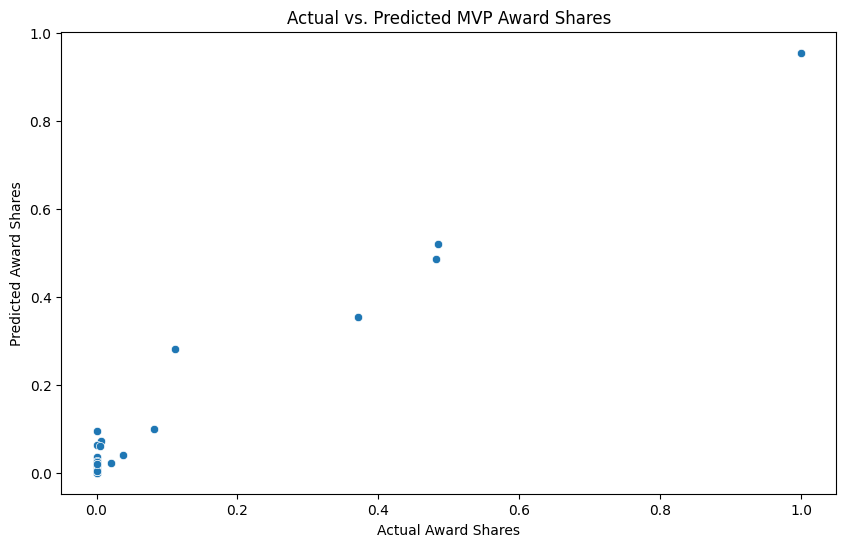

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Random Forest model
regr = RandomForestRegressor(random_state=0)

# Define hyperparameters to search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a pipeline with RandomizedSearchCV
rf_pipeline = Pipeline([
    ('rf', RandomizedSearchCV(regr, param_distributions=param_dist, scoring='neg_mean_absolute_error', n_iter=10, cv=5, random_state=0))
])

# Fit the pipeline on the training data
rf_pipeline.fit(trainData, trainTargets.to_numpy()[:, 0])

# Get the best model from the pipeline
best_rf_model = rf_pipeline.named_steps['rf'].best_estimator_

# Print the best hyperparameters
print("Best Random Forest Hyperparameters:", best_rf_model.get_params())

# Predictions on validation set
valPred = best_rf_model.predict(valFold)

# Calculate MAE
mae = mean_absolute_error(valTarFold.to_numpy()[:, 0], valPred)
print(f"MAE: {mae}")

# Visualization of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=valTarFold.to_numpy()[:, 0], y=valPred)
plt.title("Actual vs. Predicted MVP Award Shares")
plt.xlabel("Actual Award Shares")
plt.ylabel("Predicted Award Shares")
plt.show()


# Model
We selected the Random Forest regression model due to its ensemble nature, which combines multiple decision trees to enhance predictive performance. This model is well-suited for regression tasks and is known for handling non-linearity in data effectively.

## Hyperparameter Tuning

To optimize the Random Forest model's performance, we employed hyperparameter tuning using RandomizedSearchCV. This technique allows us to explore a range of hyperparameter values randomly, providing a balance between computational efficiency and model performance.

### Considered Hyperparameters

- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the trees.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.

### Tuning Method - RandomizedSearchCV

RandomizedSearchCV was chosen as the hyperparameter tuning method for its ability to efficiently sample a predefined search space of hyperparameters. By randomly selecting combinations of hyperparameter values, it strikes a balance between exploration and exploitation.

## Results

The best-performing model, determined by RandomizedSearchCV, was selected based on the negative mean absolute error (neg_mean_absolute_error) scoring metric. This model's hyperparameters are presented below.

### Best Random Forest Hyperparameters

- `n_estimators`: 100
- `max_depth`: 7
- `min_samples_split`: 2
- `min_samples_leaf`: 4

## Evaluation Metric - Mean Absolute Error (MAE)

The model's performance was assessed using the mean absolute error (MAE), a metric measuring the average absolute differences between predicted and actual values. Lower MAE values indicate better predictive accuracy.

The final section includes a visualization of the actual vs. predicted MVP Award Shares on the validation set, providing insights into the model's performance. It looks linear, indicating the model did very well

### XGBoost Model

In [26]:
from xgboost import XGBRegressor

In [27]:
from xgboost import XGBRegressor
import numpy as np

# Set the option to show only the output of the last statement
%config InteractiveShell.ast_node_interactivity = 'last_expr'

validation_scores = {"season": [], "mae": [], "was_mvp": [], "was_top_two": [], "was_top_three": [], "info": []}
seasons = trainInfo.season.unique()

for season in seasons:
    print("\n")
    print(f"Season: {season}")

    trainFold = trainData[trainInfo["season"] != season]
    trainTarFold = trainTargets[trainInfo["season"] != season]
    valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

    regr = XGBRegressor(objective='reg:squarederror', random_state=0, max_depth=6)
    regr.fit(trainFold, trainTarFold)

    valPred = regr.predict(valFold)
    mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:, 0]))
    print(f"MAE: {mae}")

    topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
    was_top_two = sum(topTwo["was_mvp"]) > 0
    topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
    was_top_three = sum(topThree["was_mvp"]) > 0
    print("Predicted top three players in MVP voting with their actual award_share:")
    print(topThree.iloc[::-1])

    mostVotes = np.argmax(valPred)
    score = np.amax(valPred)
    was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
    print(f"Predicted MVP: {player}")
    print(f"Predicted Win Share: {score}")
    print(f"Was MVP correct: {was_mvp}")

    validation_scores["season"].append(season)
    validation_scores["mae"].append(mae)
    validation_scores["was_mvp"].append(was_mvp)
    validation_scores["info"].append(valInfo.iloc[[mostVotes]])
    validation_scores["was_top_two"].append(was_top_two)
    validation_scores["was_top_three"].append(was_top_three)




Season: 2021
MAE: 0.01638974797491034
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3827    2021           Nikola Jokić   C     DEN        0.961    True     False
5621    2021          Stephen Curry  PG     GSW        0.449    True     False
5650    2021  Giannis Antetokounmpo  PF     MIL        0.345    True     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.920632004737854
Was MVP correct: True


Season: 2002
MAE: 0.014076719108208792
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4556    2002        Jason Kidd  PG     NJN        0.712    True     False
7360    2002        Tim Duncan  PF     SAS        0.757    True     False
1895    2002  Shaquille O'Neal   C     LAL        0.552    True     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.6206496953964

In [28]:
print(f"The XGBoost Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(validation_scores['was_mvp']) * 100}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(validation_scores['was_top_two']) * 100}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(validation_scores['was_top_three']) * 100}% of the time")


The XGBoost Model predicted the NBA MVP correctly 100.0% of the time
The XGBoost Model predicted the NBA MVP correctly in the top two 100.0% of the time
The XGBoost Model predicted the NBA MVP correctly in the top three 100.0% of the time


## K-Means clustering (Unsupervised)

We define a K-Means clustering model due to its simplicity, scalability and versatility. Hyperparameter tuning was performed using GridSearchCV to find the optimal number of clusters. We predict cluster labels for the validation data and evaluate the silhouette score for clustering quality. Additionally, we visualize the clustering results using scatter plots.



Season: 2021


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.3063411120515915


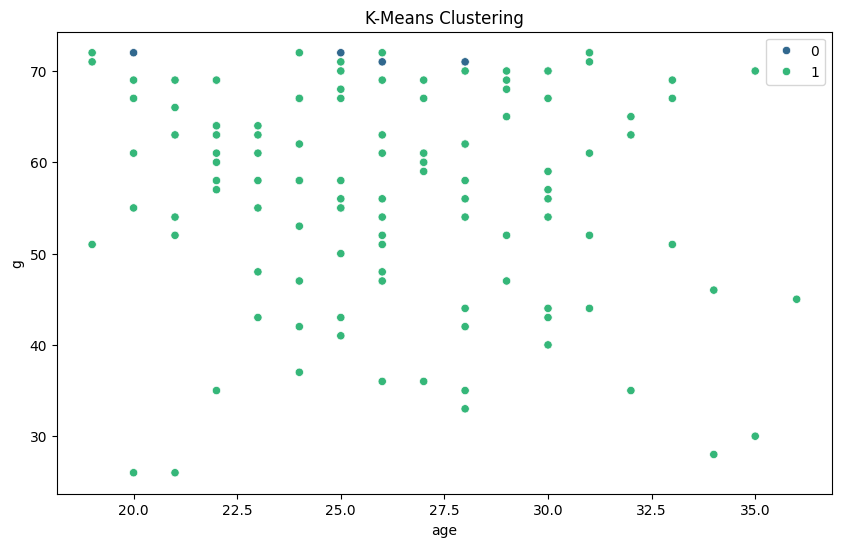



Season: 2002


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5189949222017068


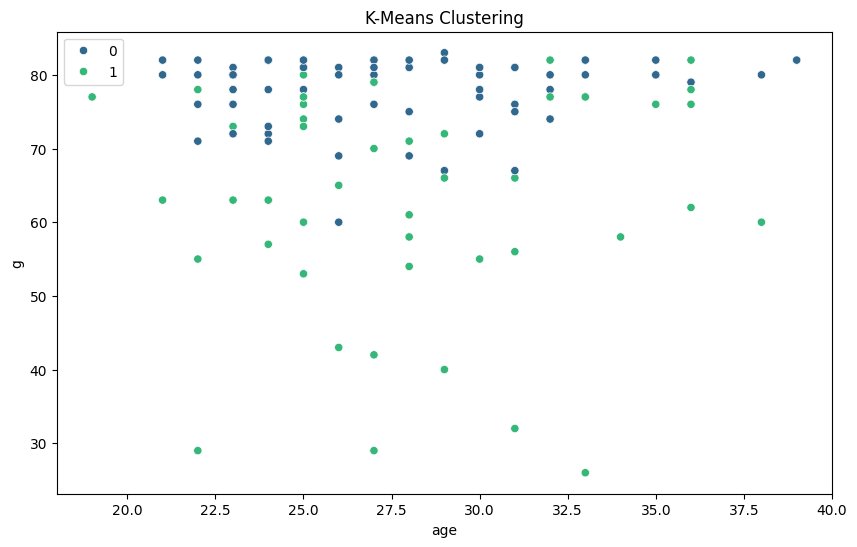



Season: 2003


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5246717228712244


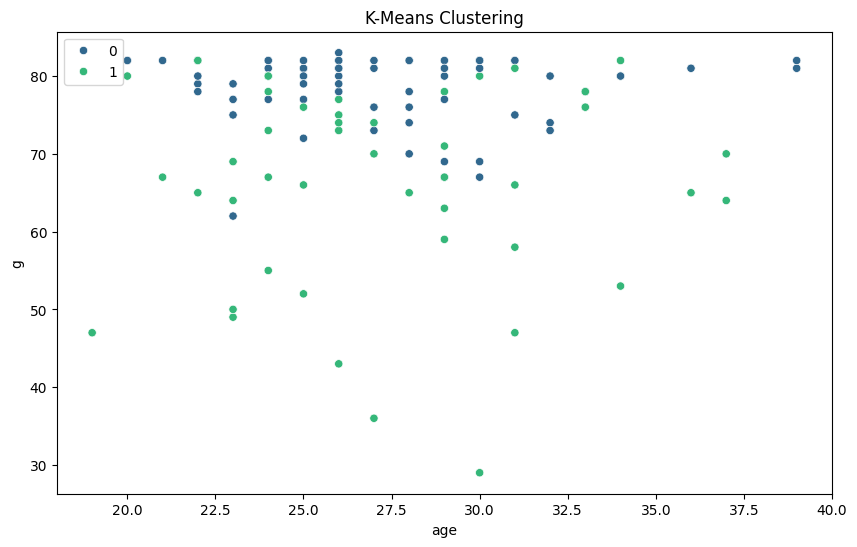



Season: 2009


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5195078545486553


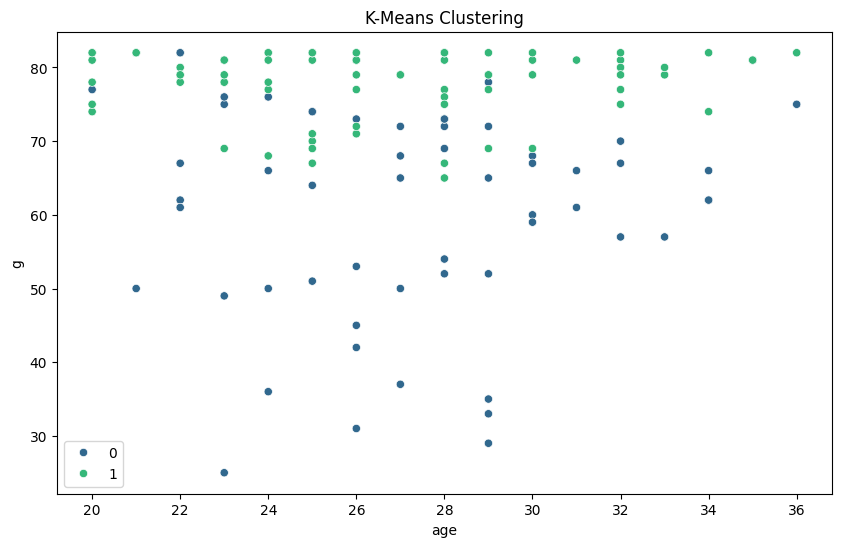



Season: 2013


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5238627119801993


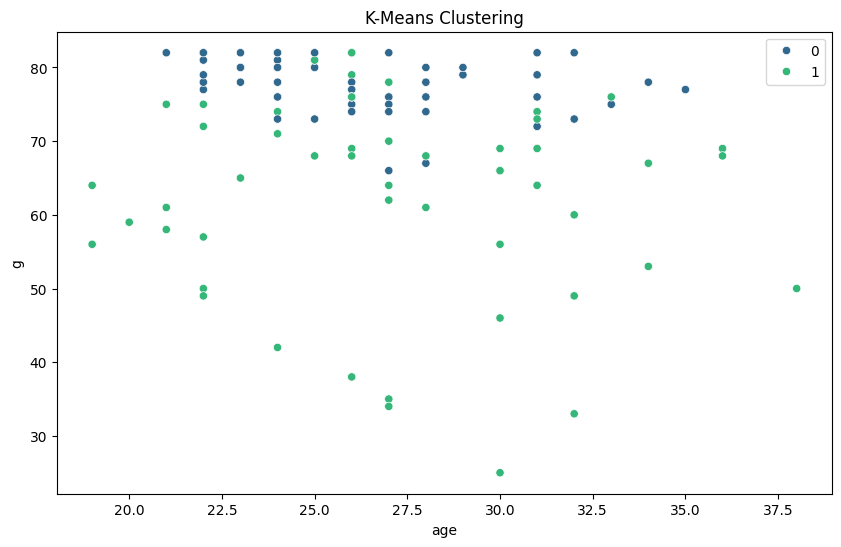



Season: 1990


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5323128286689884


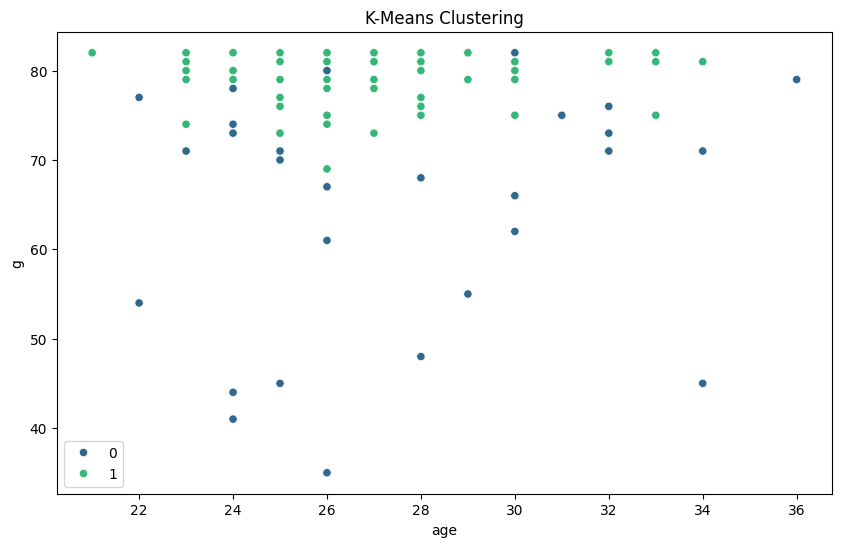



Season: 2004


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5586442710775359


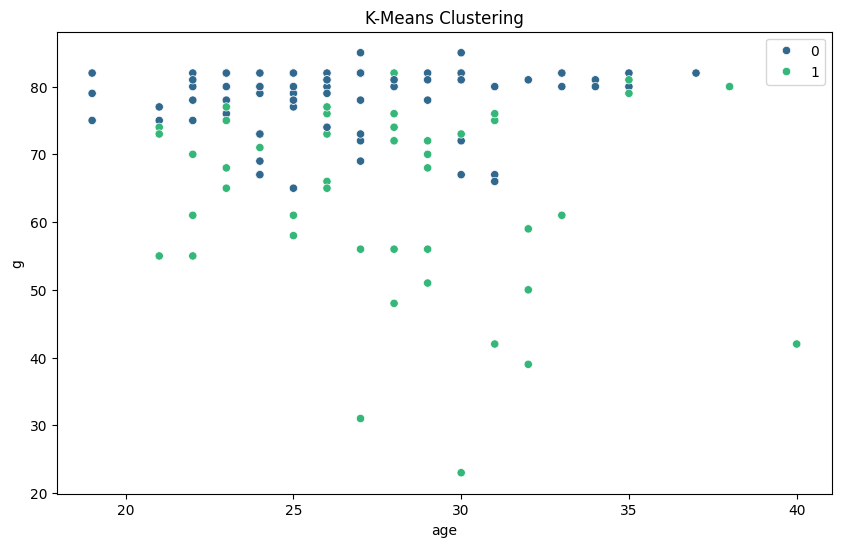



Season: 1993


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5499519302244065


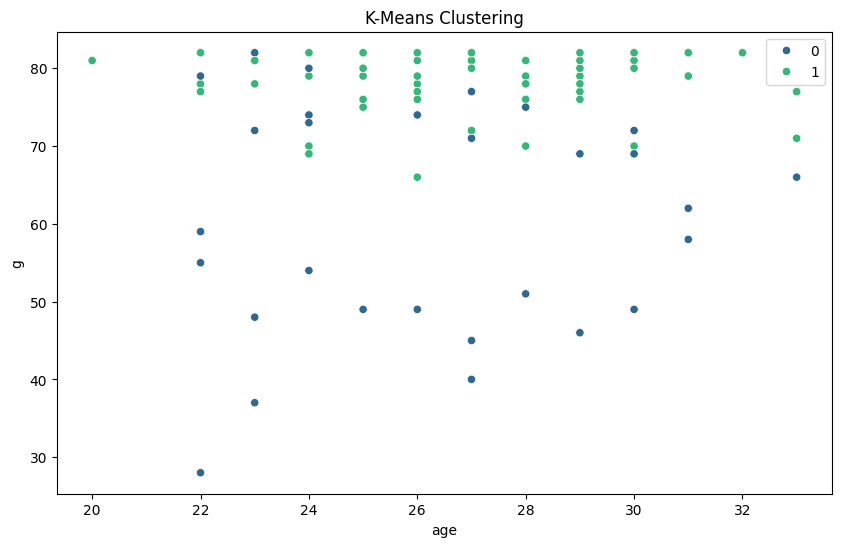



Season: 1992


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5624643248950221


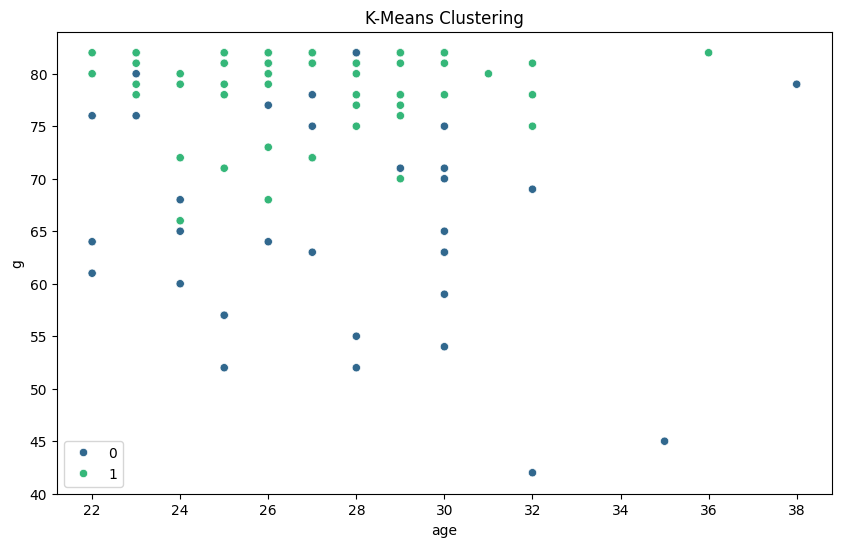



Season: 2010


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5128209196802649


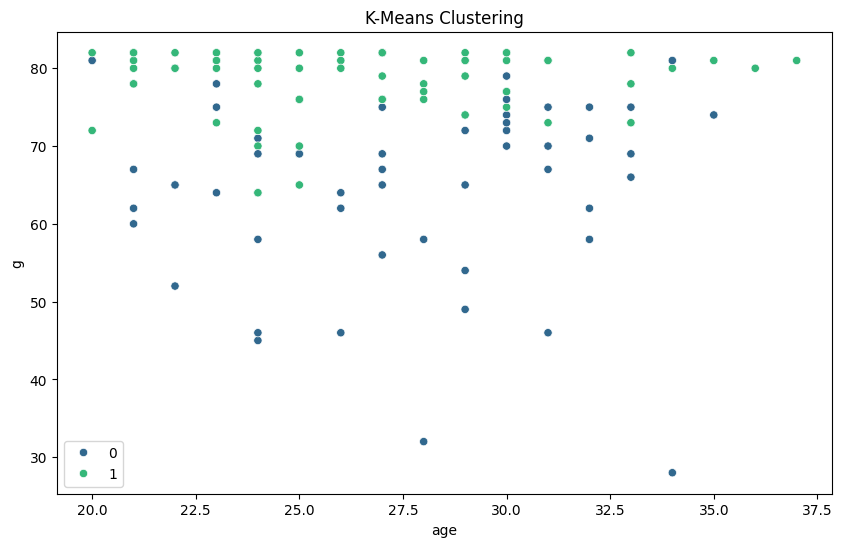



Season: 1991


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.535051545216297


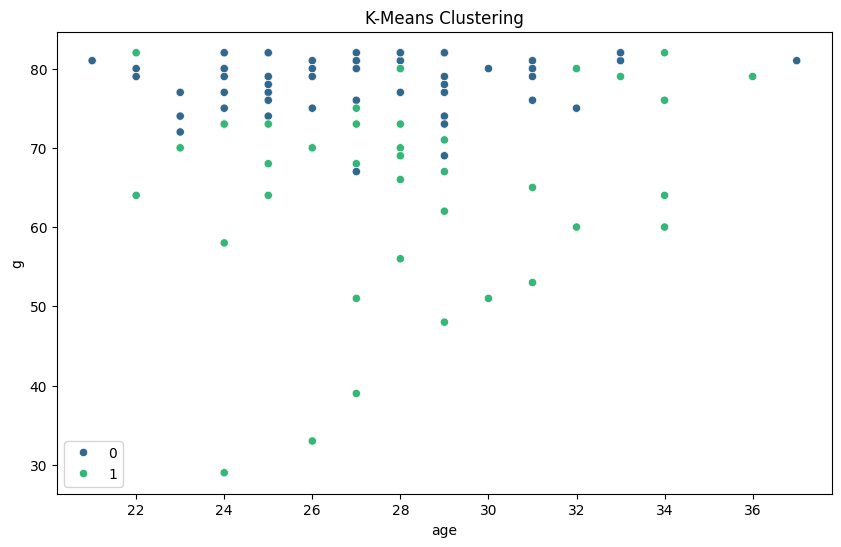



Season: 1999


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Skipping silhouette score calculation as there are not enough unique labels.


Season: 1989


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.4516875017832074


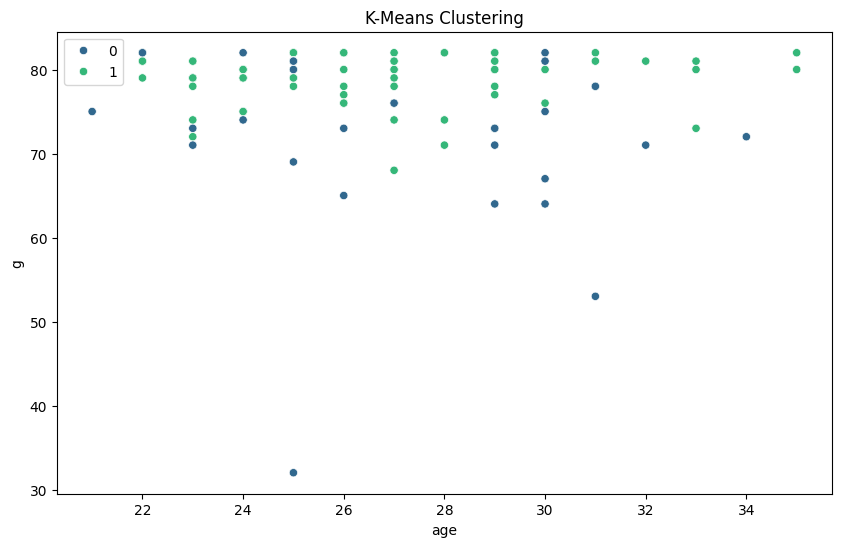



Season: 2007


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5389502325818232


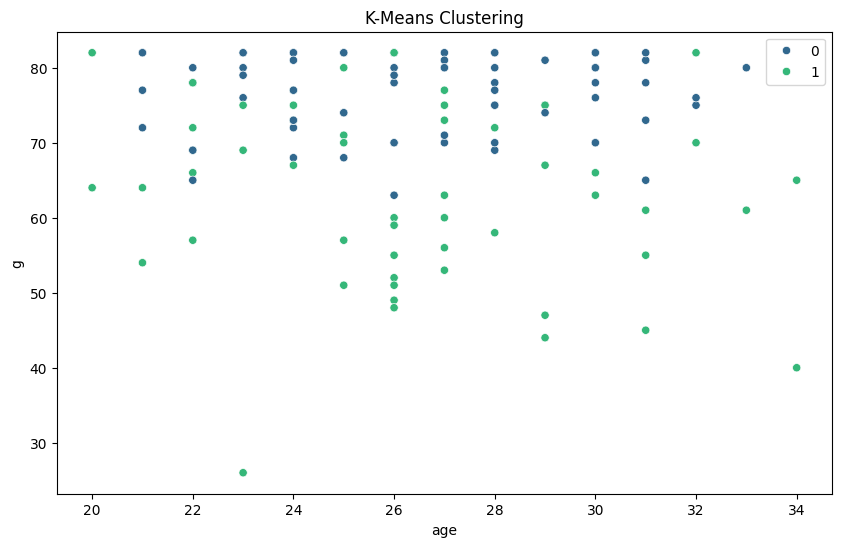



Season: 2017


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5024582525237344


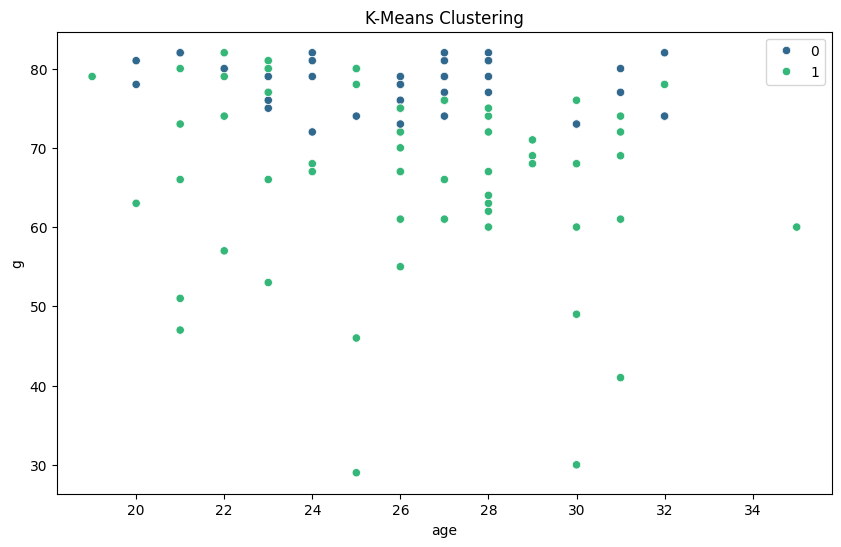



Season: 1995


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5510016372045291


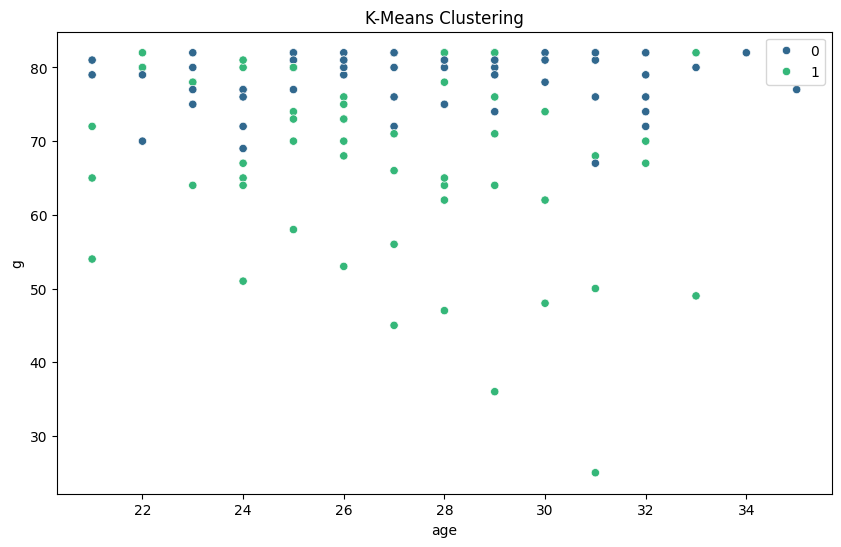



Season: 1986


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.48420279850213027


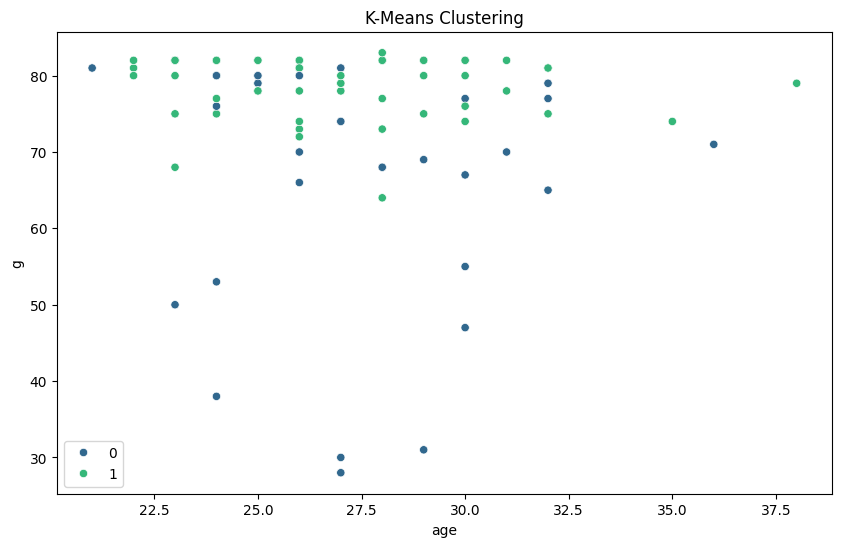



Season: 2020


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.3789393539884984


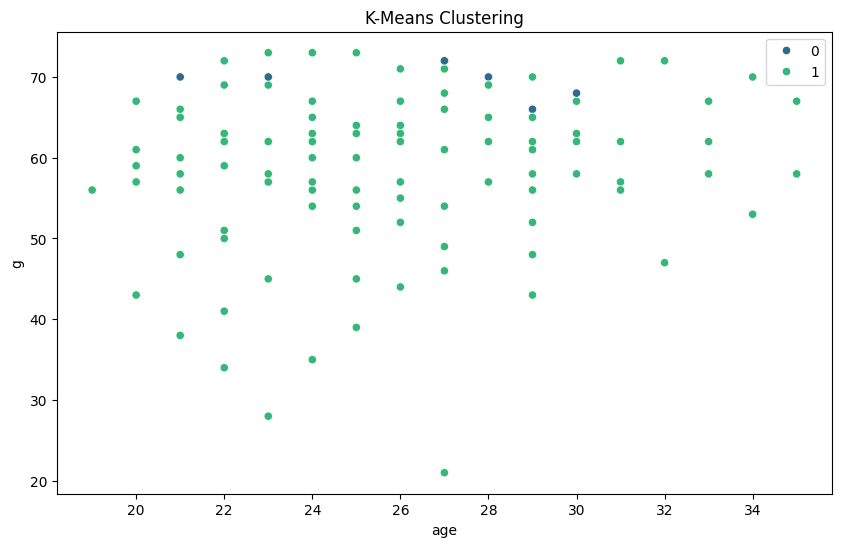



Season: 2018


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.4981687652439472


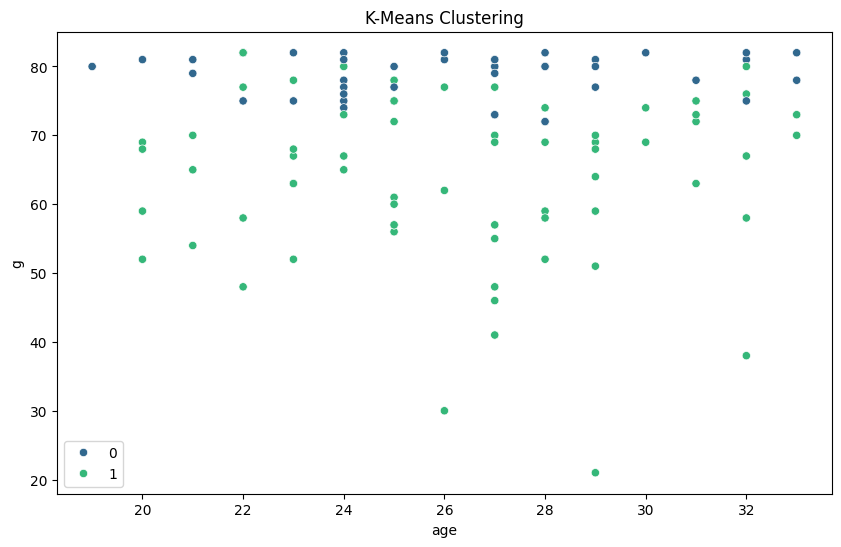



Season: 2008


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5557778468106203


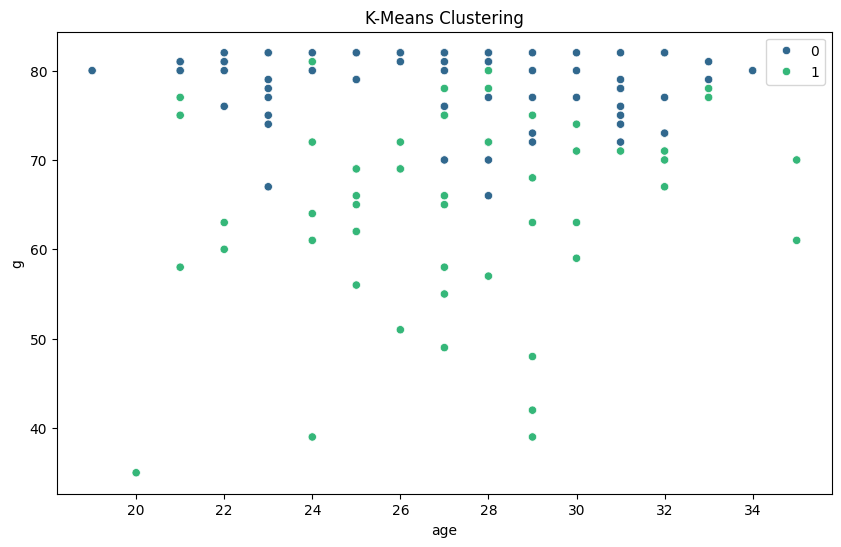



Season: 2016


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.45250402787415434


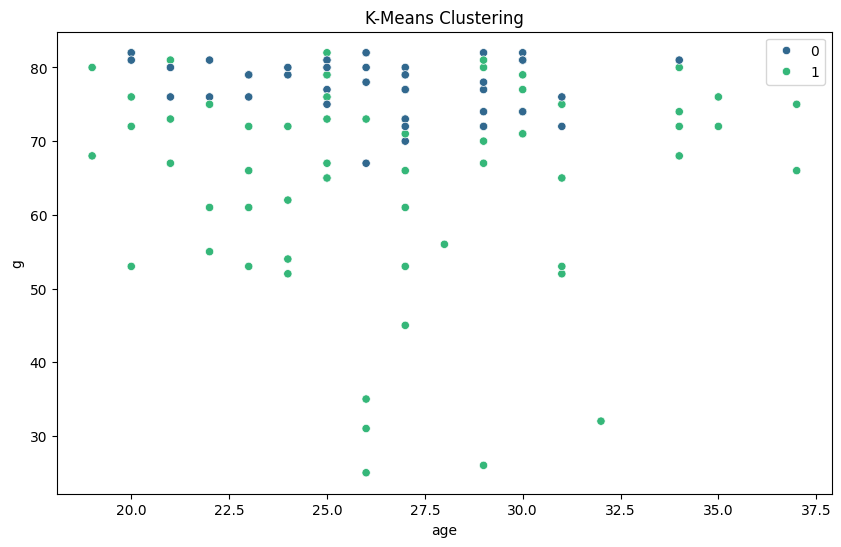



Season: 1994


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5399344796104951


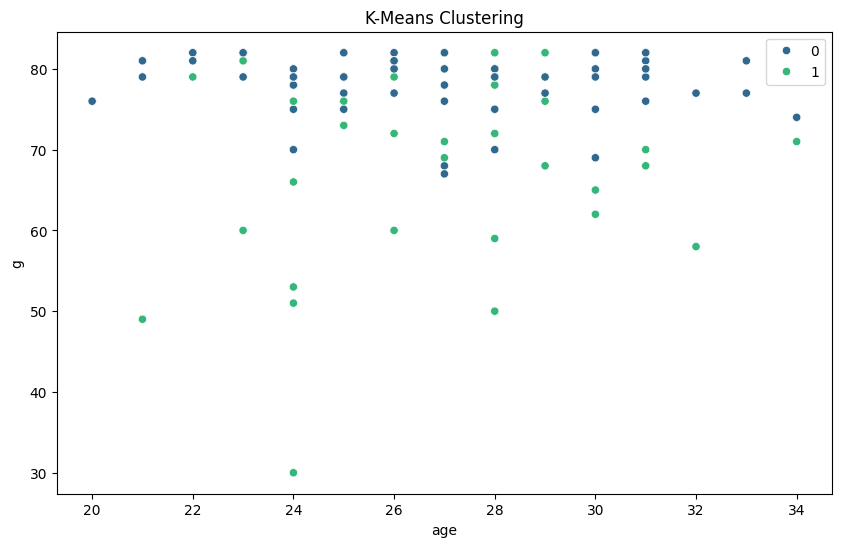



Season: 2001


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5404979646862518


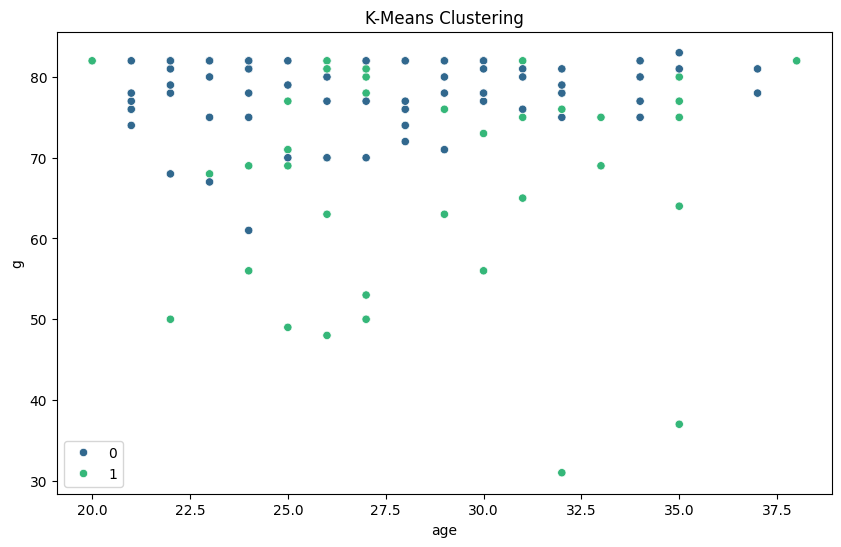



Season: 1997


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.6014449378549858


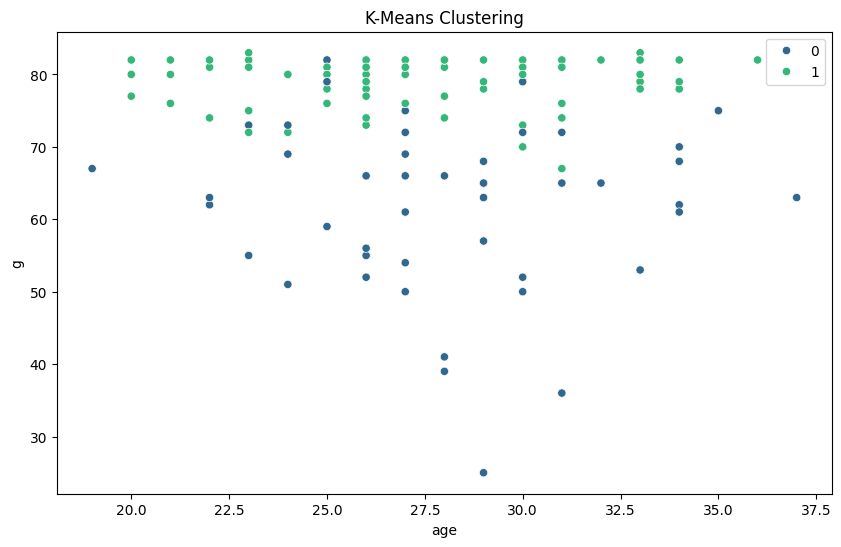



Season: 1982


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5687711108366256


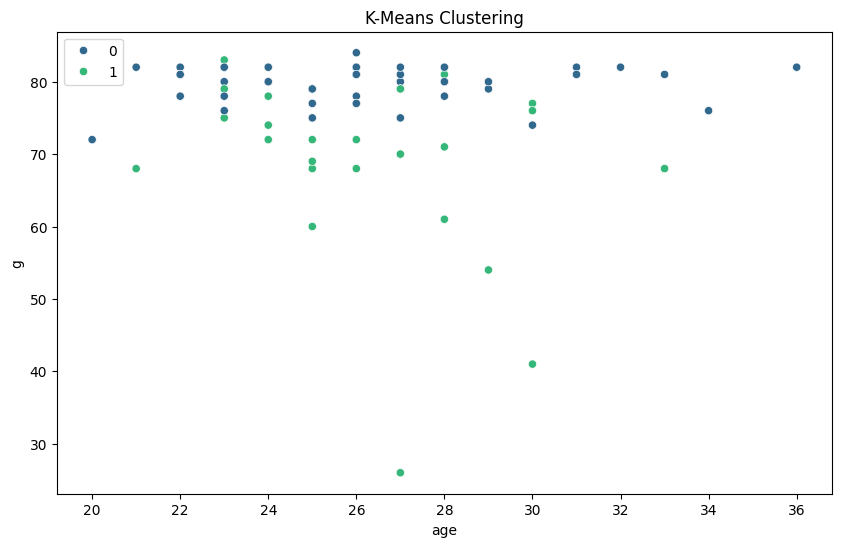



Season: 2015


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.353696128635118


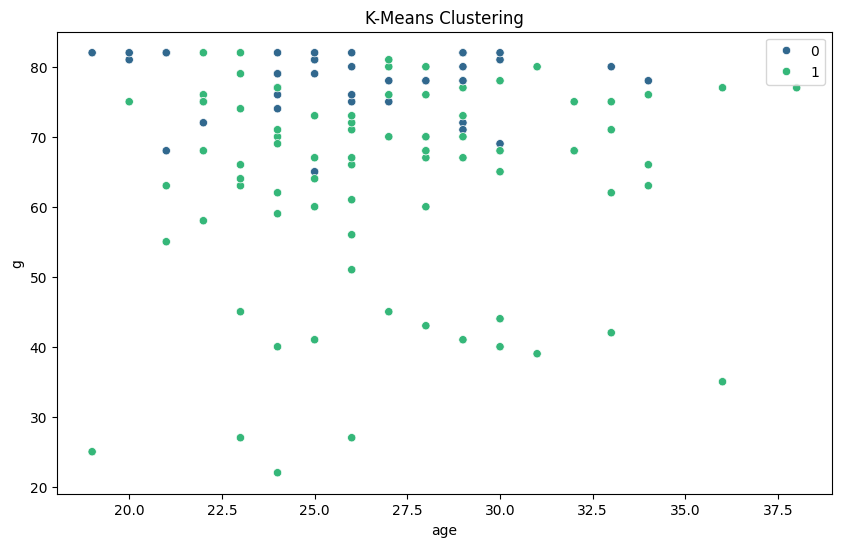



Season: 1996


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5387783027871746


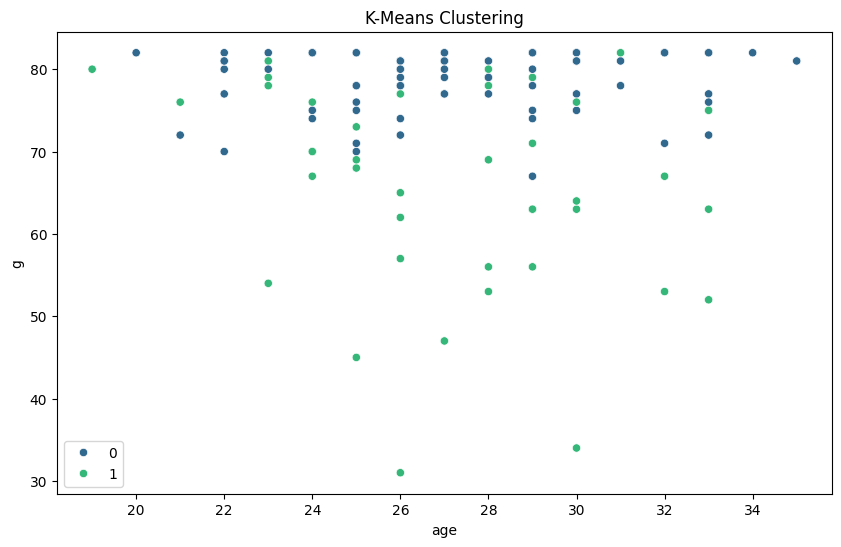



Season: 2005


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.563031350427782


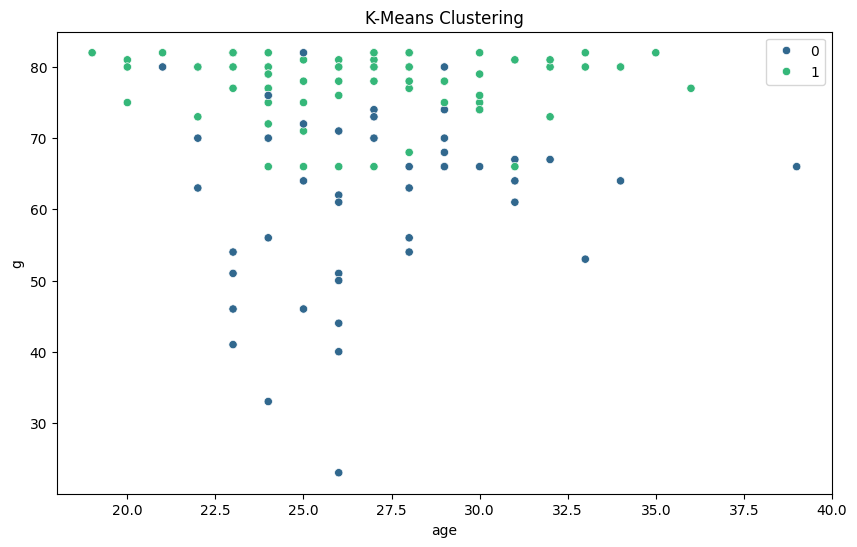



Season: 1983


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5274415805027817


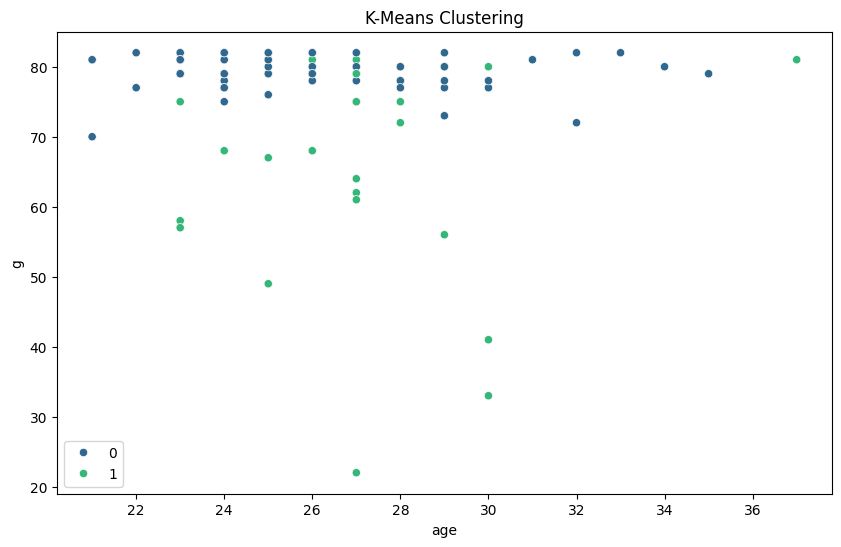



Season: 1984


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5476655669443115


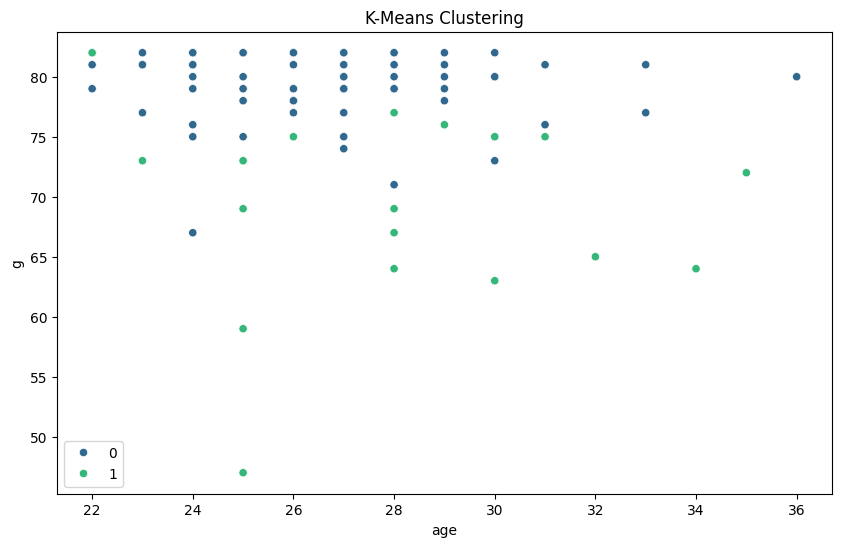



Season: 2011


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5317119349798072


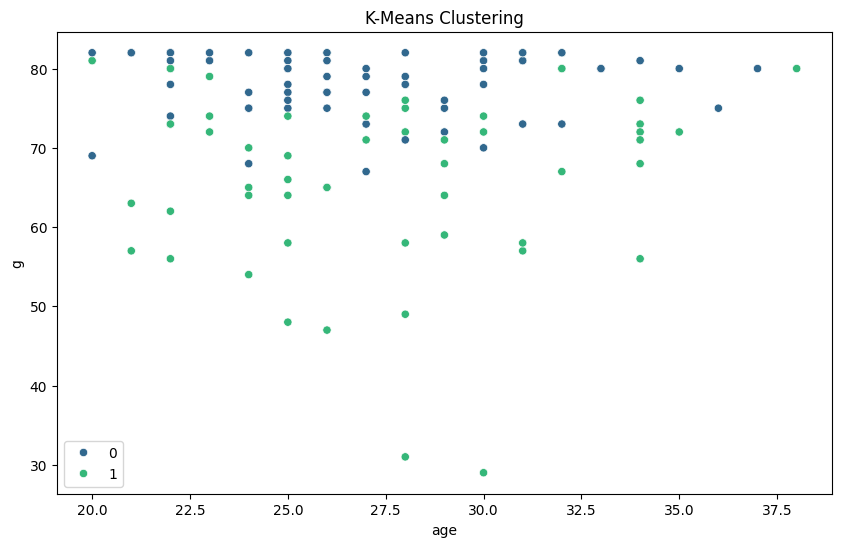



Season: 2014


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.4976807130586632


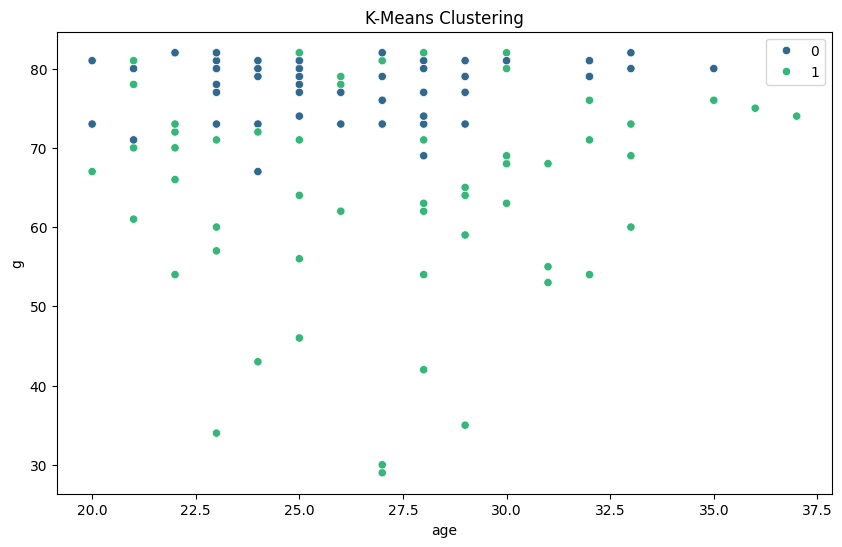



Season: 1985


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5118371042687083


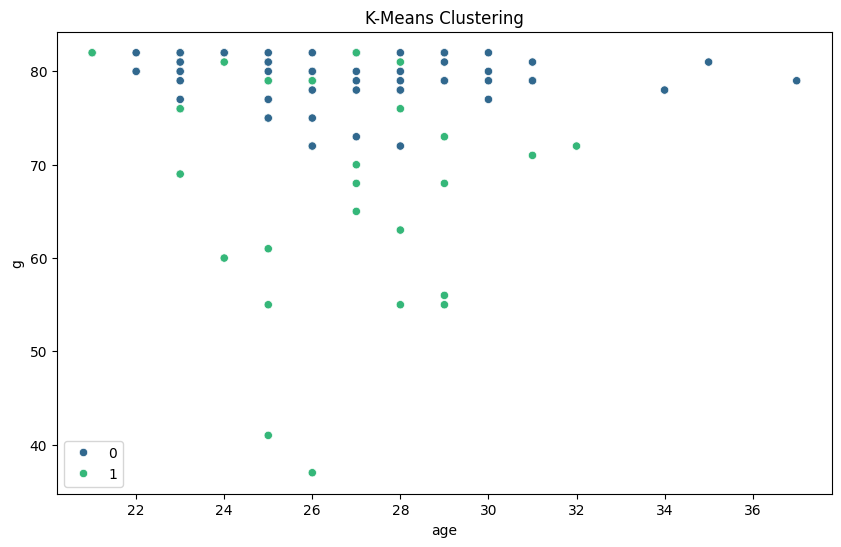



Season: 1987


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.576274676484537


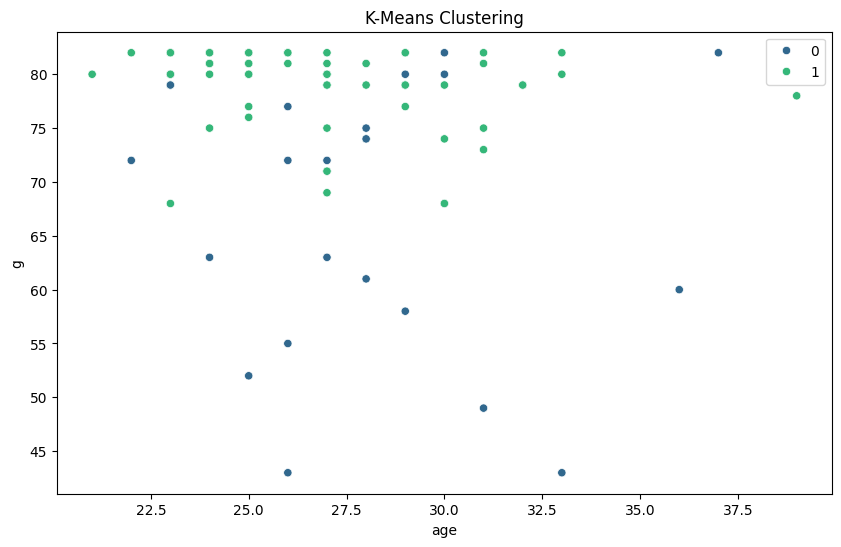



Season: 2012


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.29971419153576806


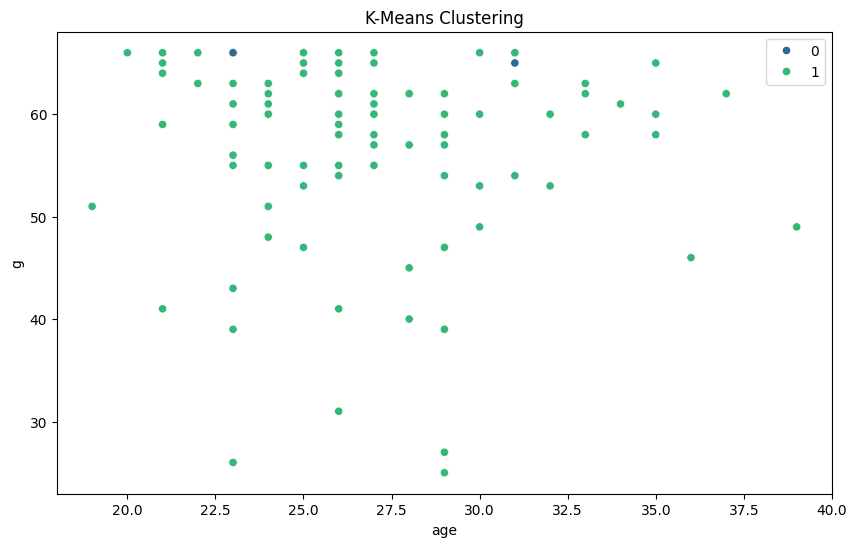



Season: 1988


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.6049571318598321


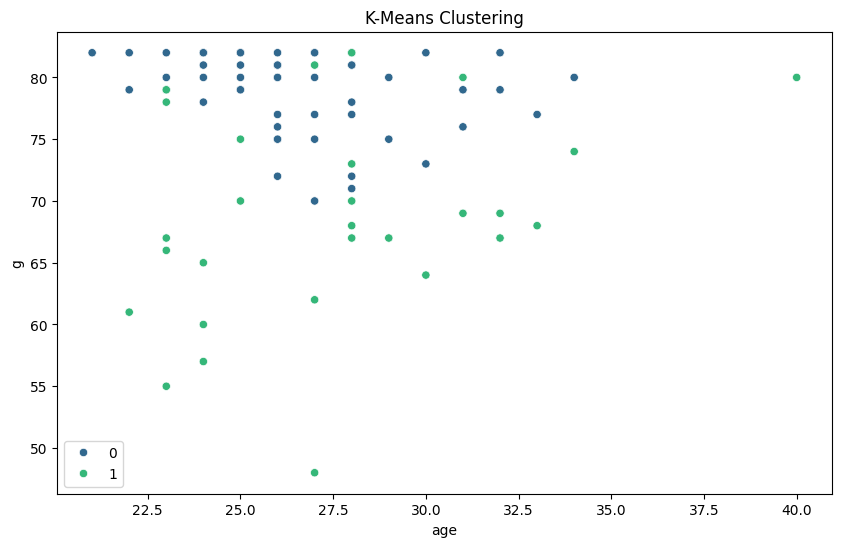



Season: 1998


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5346989240288568


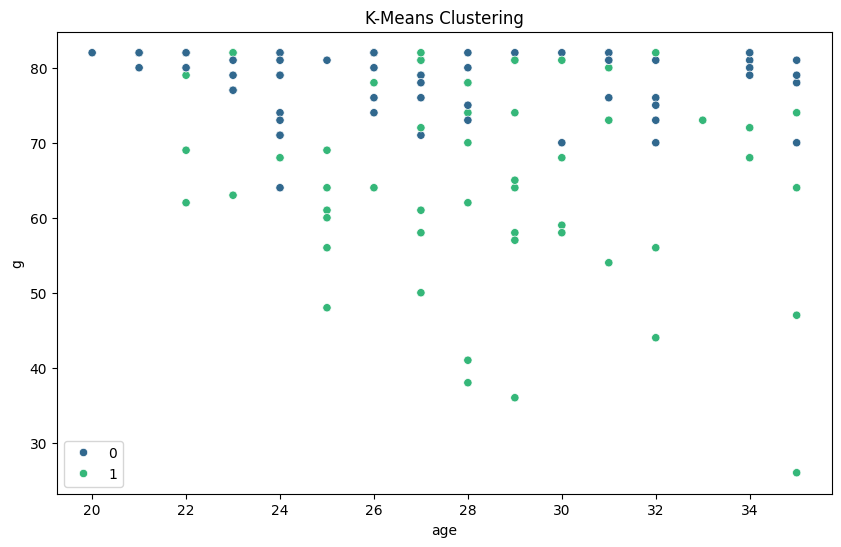



Season: 2006


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5642586697503226


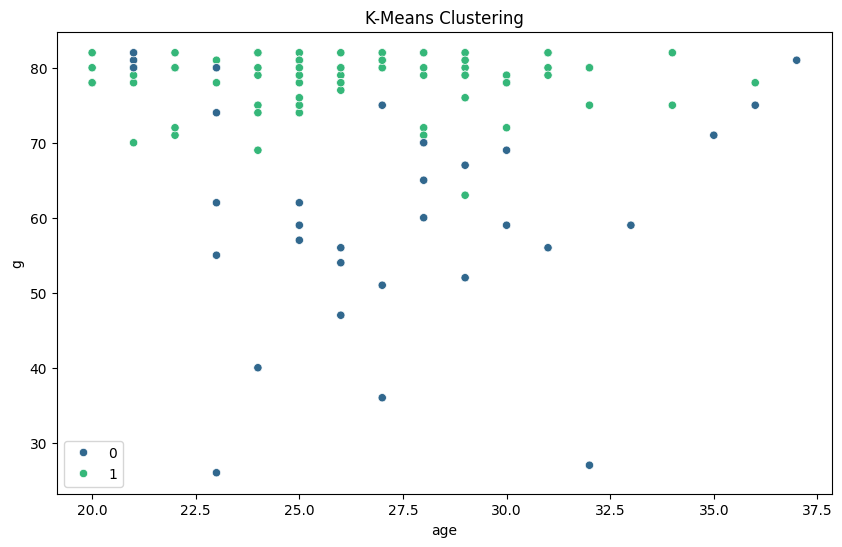



Season: 2019


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.43442502295363156


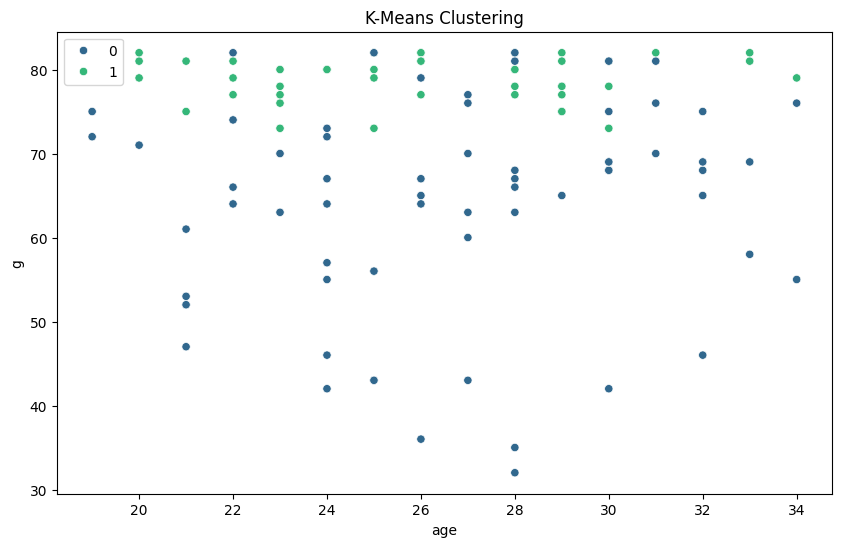



Season: 2000


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defa

Best K-Means Hyperparameters: {'n_clusters': 2}
Silhouette Score: 0.5465394902917267


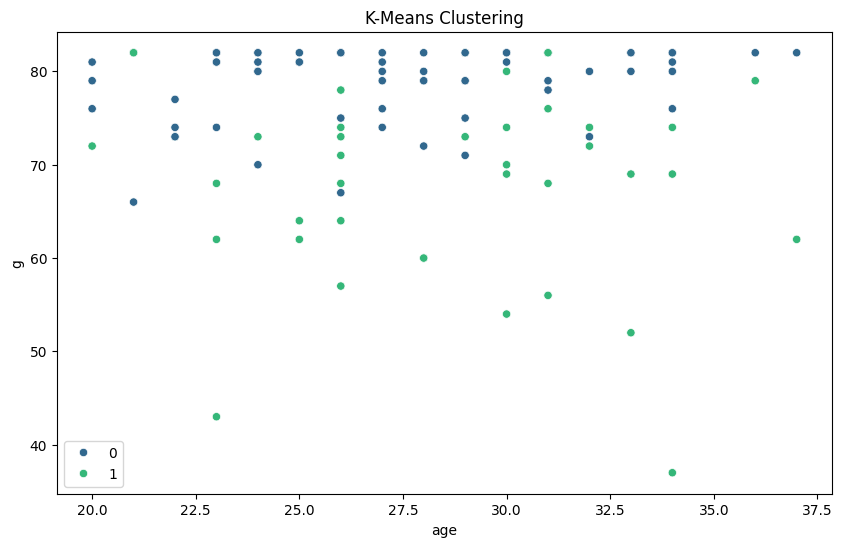

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have 'trainData' available with features suitable for clustering

validation_scores_kmeans = {"season": [], "silhouette_score": [], "cluster_labels": []}
seasons = trainInfo.season.unique()

for season in seasons:
    print("\n")
    print(f"Season: {season}")

    trainFold = trainData[trainInfo["season"] != season]
    valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
    valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

    # Define the model
    kmeans_model = KMeans(random_state=0)

    # Define hyperparameters to search
    kmeans_param_grid = {
        'n_clusters': [2, 3, 4, 5]
    }

    # Create a scorer for silhouette score
    silhouette_scorer = make_scorer(silhouette_score)

    # Create a pipeline with GridSearchCV
    kmeans_pipeline = GridSearchCV(kmeans_model, param_grid=kmeans_param_grid, scoring=silhouette_scorer, cv=5)
    kmeans_pipeline.fit(trainFold)

    # Predict cluster labels for the data
    kmeans_labels = kmeans_pipeline.predict(valFold)

    # Check if there are at least two unique labels
    if len(set(kmeans_labels)) < 2:
        print("Skipping silhouette score calculation as there are not enough unique labels.")
        continue

    # Evaluate silhouette score for clustering quality
    silhouette_avg = silhouette_score(valFold, kmeans_labels)
    print("Best K-Means Hyperparameters:", kmeans_pipeline.best_params_)
    print("Silhouette Score:", silhouette_avg)

    # Visualize the clustering results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=valFold.iloc[:, 0], y=valFold.iloc[:, 1], hue=kmeans_labels, palette='viridis')
    plt.title("K-Means Clustering")
    plt.show()

    validation_scores_kmeans["season"].append(season)
    validation_scores_kmeans["silhouette_score"].append(silhouette_avg)
    validation_scores_kmeans["cluster_labels"].append(kmeans_labels)

In [30]:
# Assuming validation_scores_kmeans is already populated with silhouette scores

# Combine the season and silhouette_score into tuples
season_scores = list(zip(validation_scores_kmeans["season"], validation_scores_kmeans["silhouette_score"]))

# Sort the tuples based on silhouette_score in descending order
sorted_season_scores = sorted(season_scores, key=lambda x: x[1], reverse=True)

# Print the sorted results
for season, silhouette_score in sorted_season_scores:
    print(f"Season: {season}, Silhouette Score: {silhouette_score}")


Season: 1988, Silhouette Score: 0.6049571318598321
Season: 1997, Silhouette Score: 0.6014449378549858
Season: 1987, Silhouette Score: 0.576274676484537
Season: 1982, Silhouette Score: 0.5687711108366256
Season: 2006, Silhouette Score: 0.5642586697503226
Season: 2005, Silhouette Score: 0.563031350427782
Season: 1992, Silhouette Score: 0.5624643248950221
Season: 2004, Silhouette Score: 0.5586442710775359
Season: 2008, Silhouette Score: 0.5557778468106203
Season: 1995, Silhouette Score: 0.5510016372045291
Season: 1993, Silhouette Score: 0.5499519302244065
Season: 1984, Silhouette Score: 0.5476655669443115
Season: 2000, Silhouette Score: 0.5465394902917267
Season: 2001, Silhouette Score: 0.5404979646862518
Season: 1994, Silhouette Score: 0.5399344796104951
Season: 2007, Silhouette Score: 0.5389502325818232
Season: 1996, Silhouette Score: 0.5387783027871746
Season: 1991, Silhouette Score: 0.535051545216297
Season: 1998, Silhouette Score: 0.5346989240288568
Season: 1990, Silhouette Score: 0.

## A model such as this works much better with supervised learning, and the results are pretty good. However, due to bias in MVP voting, the model can never be perfect